In [4]:
# # Install necessary packages
# !pip install gspread google-auth google-auth-oauthlib google-auth-httplib2

import gspread
import pandas as pd
from google.colab import auth
from google.auth import default

# Authenticate
auth.authenticate_user()

# Get credentials explicitly from google-auth
creds, _ = default(scopes=['https://www.googleapis.com/auth/spreadsheets',
                          'https://www.googleapis.com/auth/drive'])

# Use the google-auth credentials with gspread
gc = gspread.authorize(creds)

# Open the spreadsheet
spreadsheet = gc.open_by_key('1uD42ioOXcLV0o8pk9CHlYsPmNJVNbBHijgAgLD2A6jQ')

# Get the first sheet
worksheet = spreadsheet.get_worksheet(0)

# Get all values from the worksheet
data = worksheet.get_all_records()

# Convert to DataFrame
df = pd.DataFrame(data)

print(df)

   Job_ID  Release_Date  Processing_Time  Due_Date  Weight
0       1             0                5        12       3
1       2             3                8        18       4
2       3             5                3        14       5
3       4             8                6        20       2
4       5            11                4        19       3
5       6            15                7        28       1
6       7            17                2        22       4



FCFS Schedule Results:
Job sequence: [1, 2, 3, 4, 5, 6, 7]
Makespan (total completion time): 35

Detailed Job Metrics:
   Job_ID  Start_Time  Completion_Time  Wait_Time  Flow_Time  Lateness  \
0       1           0                5          0          5        -7   
1       2           5               13          2         10        -5   
2       3          13               16          8         11         2   
3       4          16               22          8         14         2   
4       5          22               26         11         15         7   
5       6          26               33         11         18         5   
6       7          33               35         16         18        13   

   Tardiness  
0          0  
1          0  
2          2  
3          2  
4          7  
5          5  
6         13  

Summary Statistics:
            Metric  Total  Average  Maximum
0  Completion Time    150    21.43       35
1        Wait Time     56     8.00       16
2        Flow 

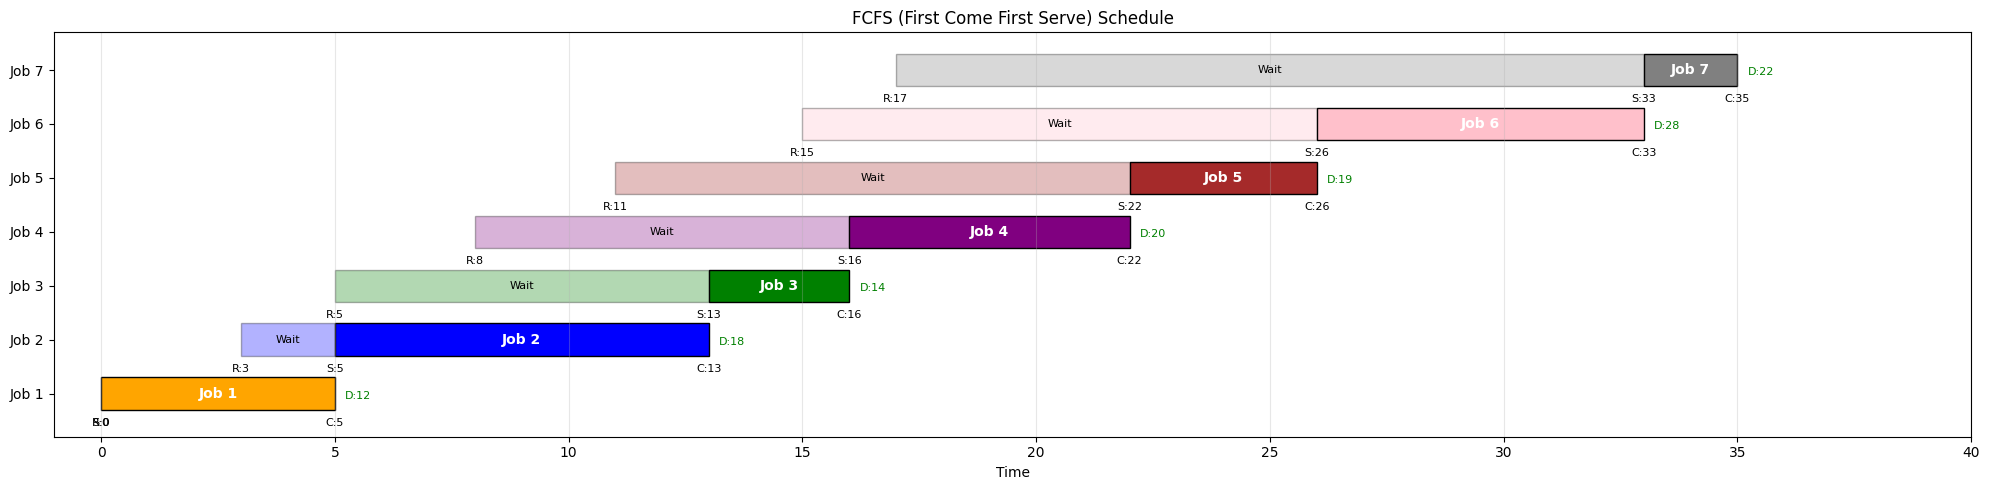

In [26]:
# POPULAR DISPATCHING RULES: FCFS, SPT, LPT, EDD, ERD, WSPT, Random

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd

def FCFS(jobs_df):
    """
    First Come First Serve scheduling algorithm with comprehensive metrics
    """
    # Make a copy (no sorting - take jobs in the order they appear)
    df = jobs_df.copy()

    # Initialize variables
    current_time = 0
    start_times = []
    completion_times = []
    waiting_times = []
    flow_times = []
    lateness_values = []
    tardiness_values = []

    # Process each job in the order they appear
    for idx, job in df.iterrows():
        # Update current time (job can't start before its release date)
        current_time = max(current_time, job['Release_Date'])

        # Calculate start time for this job
        start_time = current_time
        start_times.append(start_time)

        # Process the job
        current_time += job['Processing_Time']
        completion_time = current_time
        completion_times.append(completion_time)

        # Calculate metrics
        waiting_time = start_time - job['Release_Date']
        flow_time = completion_time - job['Release_Date']
        lateness = completion_time - job['Due_Date']
        tardiness = max(0, completion_time - job['Due_Date'])

        # Save results
        waiting_times.append(waiting_time)
        flow_times.append(flow_time)
        lateness_values.append(lateness)
        tardiness_values.append(tardiness)

    # Add results to the dataframe
    df['Start_Time'] = start_times
    df['Completion_Time'] = completion_times
    df['Wait_Time'] = waiting_times
    df['Flow_Time'] = flow_times
    df['Lateness'] = lateness_values
    df['Tardiness'] = tardiness_values

    # Calculate total and average metrics
    total_completion_time = sum(completion_times)
    avg_completion_time = round(total_completion_time / len(jobs_df), 2)
    total_waiting_time = sum(waiting_times)
    avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
    total_flow_time = sum(flow_times)
    avg_flow_time = round(total_flow_time / len(jobs_df), 2)
    total_lateness = sum(lateness_values)
    avg_lateness = round(total_lateness / len(jobs_df), 2)
    total_tardiness = sum(tardiness_values)
    avg_tardiness = round(total_tardiness / len(jobs_df), 2)
    max_tardiness = max(tardiness_values)
    makespan = max(completion_times)

    # Calculate other metrics
    total_processing_time = sum(df['Processing_Time'])
    utilization = round((total_processing_time / total_flow_time) * 100, 2)  # in percentage
    avg_jobs_in_system = round(total_flow_time / total_processing_time, 2)
    num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

    # Weighted metrics (make sure 'Weight' column exists)
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default weight of 1 if not provided

    weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
    weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
    weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
    weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

    sum_weighted_completion = sum(weighted_completion_times)
    sum_weighted_flow = sum(weighted_flow_times)
    sum_weighted_wait = sum(weighted_wait_times)
    sum_weighted_tardiness = sum(weighted_tardiness)

    # Print results
    print("\nFCFS Schedule Results:")
    print(f"Job sequence: {df['Job_ID'].tolist()}")
    print(f"Makespan (total completion time): {makespan}")

    # Create a results table for all individual job metrics
    results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                        'Flow_Time', 'Lateness', 'Tardiness']]
    print("\nDetailed Job Metrics:")
    print(results_table)

    # Create a summary table with averages
    summary_data = {
        'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
        'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
        'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
        'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
    }
    summary_table = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_table)

    # Create additional metrics table
    additional_metrics = {
        'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                  'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
        'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                 sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
    }
    additional_table = pd.DataFrame(additional_metrics)
    print("\nAdditional Metrics:")
    print(additional_table)

    # Visualize the schedule
    visualize_fcfs_schedule(df)

    return df, results_table, summary_table, additional_table

def visualize_fcfs_schedule(df):
    """Visualize the FCFS schedule with a Gantt chart"""
    # Set up the figure
    fig, ax = plt.subplots(figsize=(20, 5))

    # Define colors for jobs
    colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    y_position = 0
    y_ticks = []
    y_labels = []

    # Draw jobs in FCFS order
    for idx, job in df.iterrows():
        job_id = int(job['Job_ID'])
        release_time = job['Release_Date']
        start_time = job['Start_Time']
        duration = job['Processing_Time']
        completion_time = job['Completion_Time']
        due_date = job['Due_Date']

        # Choose color based on job index
        color = colors[job_id % len(colors)]

        # Draw waiting time (lighter shade)
        if start_time > release_time:
            waiting_rect = patches.Rectangle(
                (release_time, y_position),
                start_time - release_time,
                0.6,
                linewidth=1,
                edgecolor='black',
                facecolor=color,
                alpha=0.3
            )
            ax.add_patch(waiting_rect)
            ax.text(
                release_time + (start_time - release_time)/2,
                y_position + 0.3,
                'Wait',
                ha='center',
                va='center',
                fontsize=8
            )

        # Draw processing time (full color)
        process_rect = patches.Rectangle(
            (start_time, y_position),
            duration,
            0.6,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(process_rect)

        # Add job ID text in the center of the rectangle
        ax.text(
            start_time + duration/2,
            y_position + 0.3,
            f"Job {job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Add time markers
        ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
        ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

        # Next job position
        y_position += 1
        y_ticks.append(y_position - 0.7)
        y_labels.append(f"Job {job_id}")

    # Set up the axis
    max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
    ax.set_xlim(-1, max_time)
    ax.set_ylim(-0.5, y_position)

    # Add time markers
    time_ticks = np.arange(0, max_time + 5, 5)
    ax.set_xticks(time_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_title('FCFS (First Come First Serve) Schedule')

    plt.tight_layout()
    plt.show()

# Example usage:
fcfs_results, metrics_table, summary_table, additional_table = FCFS(df)


SPT Schedule Results:
Job sequence: [7, 3, 5, 1, 4, 6, 2]
Makespan (total completion time): 52

Detailed Job Metrics:
   Job_ID  Start_Time  Completion_Time  Wait_Time  Flow_Time  Lateness  \
6       7          17               19          0          2        -3   
2       3          19               22         14         17         8   
4       5          22               26         11         15         7   
0       1          26               31         26         31        19   
3       4          31               37         23         29        17   
5       6          37               44         22         29        16   
1       2          44               52         41         49        34   

   Tardiness  
6          0  
2          8  
4          7  
0         19  
3         17  
5         16  
1         34  

Summary Statistics:
            Metric  Total  Average  Maximum
0  Completion Time    231    33.00       52
1        Wait Time    137    19.57       41
2        Flow T

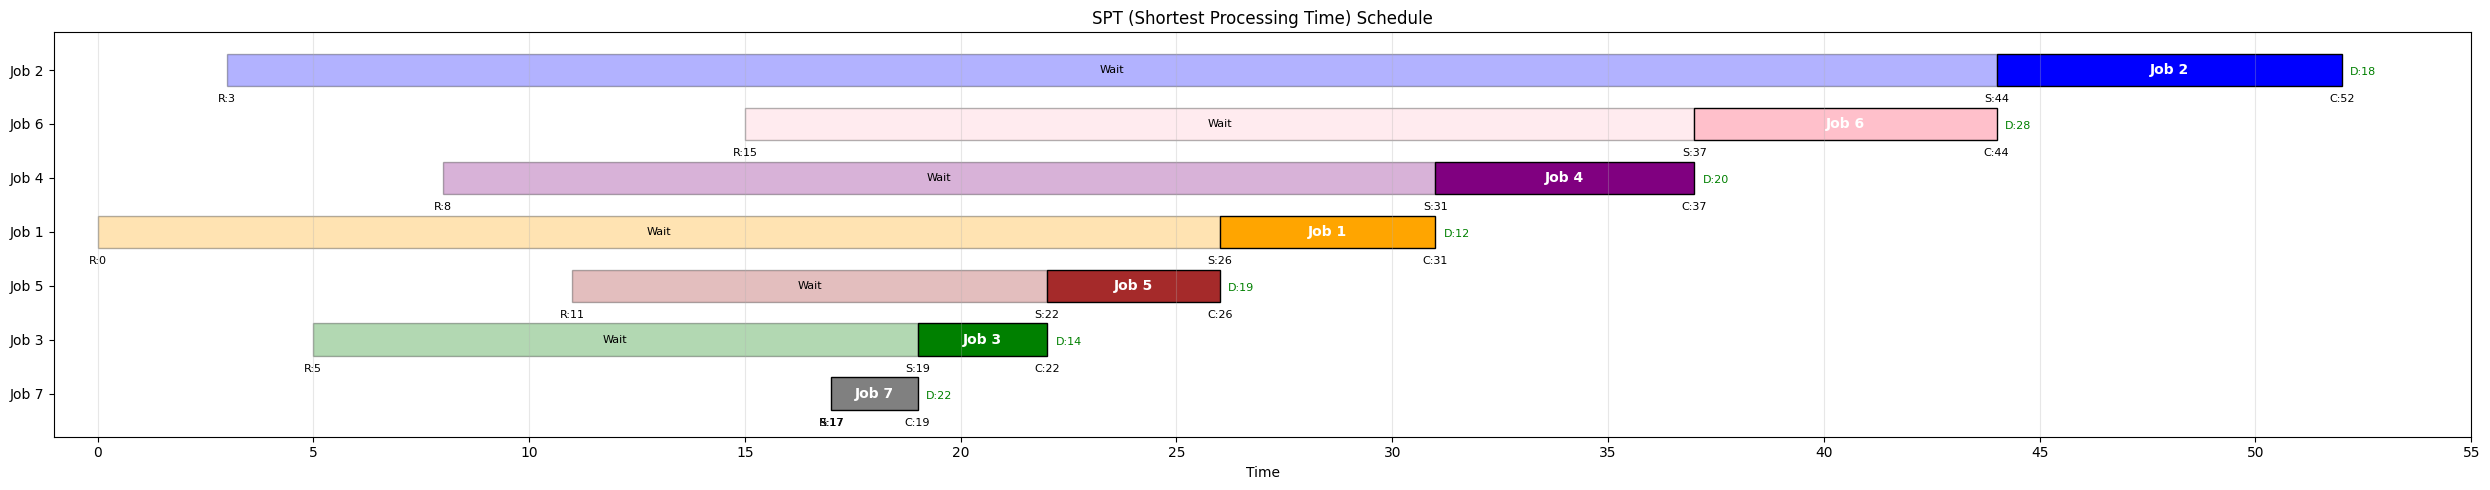

In [25]:
# POPULAR DISPATCHING RULES: SPT

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd

def SPT(jobs_df):
    # Make a copy (sorting by the increasing processing time)
    df = jobs_df.copy().sort_values('Processing_Time')

    # Initialize variables
    current_time = 0
    start_times = []
    completion_times = []
    waiting_times = []
    flow_times = []
    lateness_values = []
    tardiness_values = []

    # Process each job in the order they appear
    for idx, job in df.iterrows():
        # Update current time (job can't start before its release date)
        current_time = max(current_time, job['Release_Date'])

        # Calculate start time for this job
        start_time = current_time
        start_times.append(start_time)

        # Process the job
        current_time += job['Processing_Time']
        completion_time = current_time
        completion_times.append(completion_time)

        # Calculate metrics
        waiting_time = start_time - job['Release_Date']
        flow_time = completion_time - job['Release_Date']
        lateness = completion_time - job['Due_Date']
        tardiness = max(0, completion_time - job['Due_Date'])

        # Save results
        waiting_times.append(waiting_time)
        flow_times.append(flow_time)
        lateness_values.append(lateness)
        tardiness_values.append(tardiness)

    # Add results to the dataframe
    df['Start_Time'] = start_times
    df['Completion_Time'] = completion_times
    df['Wait_Time'] = waiting_times
    df['Flow_Time'] = flow_times
    df['Lateness'] = lateness_values
    df['Tardiness'] = tardiness_values

    # Calculate total and average metrics
    total_completion_time = sum(completion_times)
    avg_completion_time = round(total_completion_time / len(jobs_df), 2)
    total_waiting_time = sum(waiting_times)
    avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
    total_flow_time = sum(flow_times)
    avg_flow_time = round(total_flow_time / len(jobs_df), 2)
    total_lateness = sum(lateness_values)
    avg_lateness = round(total_lateness / len(jobs_df), 2)
    total_tardiness = sum(tardiness_values)
    avg_tardiness = round(total_tardiness / len(jobs_df), 2)
    max_tardiness = max(tardiness_values)
    makespan = max(completion_times)

    # Calculate other metrics
    total_processing_time = sum(df['Processing_Time'])
    utilization = round((total_processing_time / total_flow_time) * 100, 2)  # in percentage
    avg_jobs_in_system = round(total_flow_time / total_processing_time, 2)
    num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

    # Weighted metrics (make sure 'Weight' column exists)
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default weight of 1 if not provided

    weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
    weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
    weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
    weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

    sum_weighted_completion = sum(weighted_completion_times)
    sum_weighted_flow = sum(weighted_flow_times)
    sum_weighted_wait = sum(weighted_wait_times)
    sum_weighted_tardiness = sum(weighted_tardiness)

    # Print results
    print("\nSPT Schedule Results:")
    print(f"Job sequence: {df['Job_ID'].tolist()}")
    print(f"Makespan (total completion time): {makespan}")

    # Create a results table for all individual job metrics
    results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                        'Flow_Time', 'Lateness', 'Tardiness']]
    print("\nDetailed Job Metrics:")
    print(results_table)

    # Create a summary table with averages
    summary_data = {
        'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
        'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
        'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
        'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
    }
    summary_table = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_table)

    # Create additional metrics table
    additional_metrics = {
        'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                  'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
        'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                 sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
    }
    additional_table = pd.DataFrame(additional_metrics)
    print("\nAdditional Metrics:")
    print(additional_table)

    # Visualize the schedule
    visualize_spt_schedule(df)

    return df, results_table, summary_table, additional_table

def visualize_spt_schedule(df):
    """Visualize the SPT schedule with a Gantt chart"""
    # Set up the figure
    fig, ax = plt.subplots(figsize=(25, 5))

    # Define colors for jobs
    colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    y_position = 0
    y_ticks = []
    y_labels = []

    # Draw jobs in SPT order
    for idx, job in df.iterrows():
        job_id = int(job['Job_ID'])
        release_time = job['Release_Date']
        start_time = job['Start_Time']
        duration = job['Processing_Time']
        completion_time = job['Completion_Time']
        due_date = job['Due_Date']

        # Choose color based on job index
        color = colors[job_id % len(colors)]

        # Draw waiting time (lighter shade)
        if start_time > release_time:
            waiting_rect = patches.Rectangle(
                (release_time, y_position),
                start_time - release_time,
                0.6,
                linewidth=1,
                edgecolor='black',
                facecolor=color,
                alpha=0.3
            )
            ax.add_patch(waiting_rect)
            ax.text(
                release_time + (start_time - release_time)/2,
                y_position + 0.3,
                'Wait',
                ha='center',
                va='center',
                fontsize=8
            )

        # Draw processing time (full color)
        process_rect = patches.Rectangle(
            (start_time, y_position),
            duration,
            0.6,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(process_rect)

        # Add job ID text in the center of the rectangle
        ax.text(
            start_time + duration/2,
            y_position + 0.3,
            f"Job {job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Add time markers
        ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
        ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

        # Next job position
        y_position += 1
        y_ticks.append(y_position - 0.7)
        y_labels.append(f"Job {job_id}")

    # Set up the axis
    max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
    ax.set_xlim(-1, max_time)
    ax.set_ylim(-0.5, y_position)

    # Add time markers
    time_ticks = np.arange(0, max_time + 5, 5)
    ax.set_xticks(time_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_title('SPT (Shortest Processing Time) Schedule')

    plt.tight_layout()
    plt.show()

# Example usage:
spt_results, metrics_table, summary_table, additional_table = SPT(df)


LPT Schedule Results:
Job sequence: [2, 6, 4, 1, 5, 3, 7]
Makespan (total completion time): 42

Detailed Job Metrics:
   Job_ID  Start_Time  Completion_Time  Wait_Time  Flow_Time  Lateness  \
1       2           3               11          0          8        -7   
5       6          15               22          0          7        -6   
3       4          22               28         14         20         8   
0       1          28               33         28         33        21   
4       5          33               37         22         26        18   
2       3          37               40         32         35        26   
6       7          40               42         23         25        20   

   Tardiness  
1          0  
5          0  
3          8  
0         21  
4         18  
2         26  
6         20  

Summary Statistics:
            Metric  Total  Average  Maximum
0  Completion Time    213    30.43       42
1        Wait Time    119    17.00       32
2        Flow T

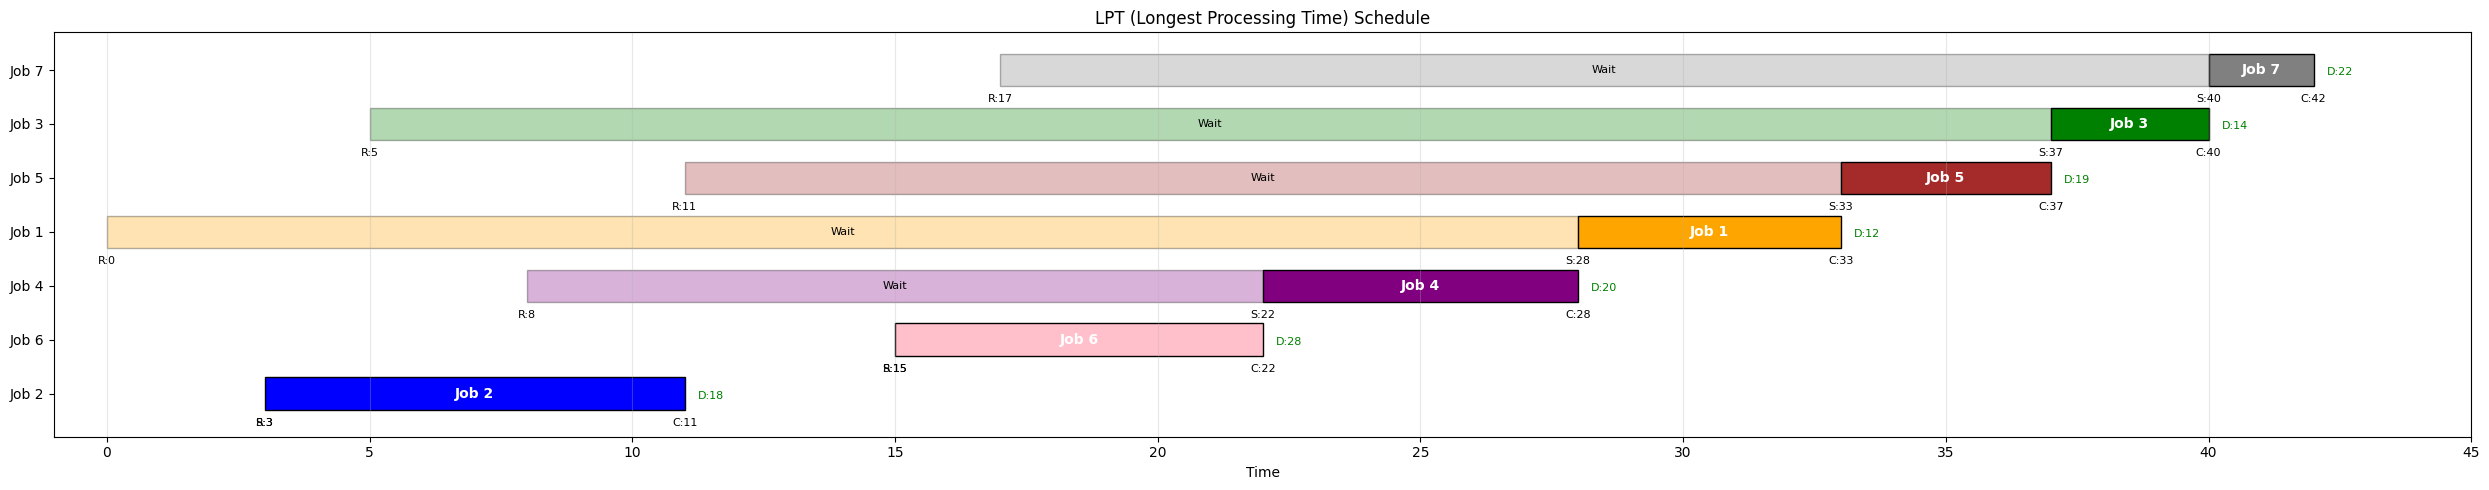

In [32]:
# POPULAR DISPATCHING RULES: LPT
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd

def LPT(jobs_df):
    # Make a copy (sorting by the decreasing processing time)
    df = jobs_df.copy().sort_values('Processing_Time', ascending = False)

    # Initialize variables
    current_time = 0
    start_times = []
    completion_times = []
    waiting_times = []
    flow_times = []
    lateness_values = []
    tardiness_values = []

    # Process each job in the order they appear
    for idx, job in df.iterrows():
        # Update current time (job can't start before its release date)
        current_time = max(current_time, job['Release_Date'])

        # Calculate start time for this job
        start_time = current_time
        start_times.append(start_time)

        # Process the job
        current_time += job['Processing_Time']
        completion_time = current_time
        completion_times.append(completion_time)

        # Calculate metrics
        waiting_time = start_time - job['Release_Date']
        flow_time = completion_time - job['Release_Date']
        lateness = completion_time - job['Due_Date']
        tardiness = max(0, completion_time - job['Due_Date'])

        # Save results
        waiting_times.append(waiting_time)
        flow_times.append(flow_time)
        lateness_values.append(lateness)
        tardiness_values.append(tardiness)

    # Add results to the dataframe
    df['Start_Time'] = start_times
    df['Completion_Time'] = completion_times
    df['Wait_Time'] = waiting_times
    df['Flow_Time'] = flow_times
    df['Lateness'] = lateness_values
    df['Tardiness'] = tardiness_values

    # Calculate total and average metrics
    total_completion_time = sum(completion_times)
    avg_completion_time = round(total_completion_time / len(jobs_df), 2)
    total_waiting_time = sum(waiting_times)
    avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
    total_flow_time = sum(flow_times)
    avg_flow_time = round(total_flow_time / len(jobs_df), 2)
    total_lateness = sum(lateness_values)
    avg_lateness = round(total_lateness / len(jobs_df), 2)
    total_tardiness = sum(tardiness_values)
    avg_tardiness = round(total_tardiness / len(jobs_df), 2)
    max_tardiness = max(tardiness_values)
    makespan = max(completion_times)

    # Calculate other metrics
    total_processing_time = sum(df['Processing_Time'])
    utilization = round((total_processing_time / total_flow_time) * 100, 2)  # in percentage
    avg_jobs_in_system = round(total_flow_time / total_processing_time, 2)
    num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

    # Weighted metrics (make sure 'Weight' column exists)
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default weight of 1 if not provided

    weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
    weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
    weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
    weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

    sum_weighted_completion = sum(weighted_completion_times)
    sum_weighted_flow = sum(weighted_flow_times)
    sum_weighted_wait = sum(weighted_wait_times)
    sum_weighted_tardiness = sum(weighted_tardiness)

    # Print results
    print("\nLPT Schedule Results:")
    print(f"Job sequence: {df['Job_ID'].tolist()}")
    print(f"Makespan (total completion time): {makespan}")

    # Create a results table for all individual job metrics
    results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                        'Flow_Time', 'Lateness', 'Tardiness']]
    print("\nDetailed Job Metrics:")
    print(results_table)

    # Create a summary table with averages
    summary_data = {
        'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
        'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
        'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
        'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
    }
    summary_table = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_table)

    # Create additional metrics table
    additional_metrics = {
        'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                  'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
        'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                 sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
    }
    additional_table = pd.DataFrame(additional_metrics)
    print("\nAdditional Metrics:")
    print(additional_table)

    # Visualize the schedule
    visualize_lpt_schedule(df)

    return df, results_table, summary_table, additional_table

def visualize_lpt_schedule(df):
    """Visualize the LPT schedule with a Gantt chart"""
    # Set up the figure
    fig, ax = plt.subplots(figsize=(25, 5))

    # Define colors for jobs
    colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    y_position = 0
    y_ticks = []
    y_labels = []

    # Draw jobs in LPT order
    for idx, job in df.iterrows():
        job_id = int(job['Job_ID'])
        release_time = job['Release_Date']
        start_time = job['Start_Time']
        duration = job['Processing_Time']
        completion_time = job['Completion_Time']
        due_date = job['Due_Date']

        # Choose color based on job index
        color = colors[job_id % len(colors)]

        # Draw waiting time (lighter shade)
        if start_time > release_time:
            waiting_rect = patches.Rectangle(
                (release_time, y_position),
                start_time - release_time,
                0.6,
                linewidth=1,
                edgecolor='black',
                facecolor=color,
                alpha=0.3
            )
            ax.add_patch(waiting_rect)
            ax.text(
                release_time + (start_time - release_time)/2,
                y_position + 0.3,
                'Wait',
                ha='center',
                va='center',
                fontsize=8
            )

        # Draw processing time (full color)
        process_rect = patches.Rectangle(
            (start_time, y_position),
            duration,
            0.6,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(process_rect)

        # Add job ID text in the center of the rectangle
        ax.text(
            start_time + duration/2,
            y_position + 0.3,
            f"Job {job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Add time markers
        ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
        ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

        # Next job position
        y_position += 1
        y_ticks.append(y_position - 0.7)
        y_labels.append(f"Job {job_id}")

    # Set up the axis
    max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
    ax.set_xlim(-1, max_time)
    ax.set_ylim(-0.5, y_position)

    # Add time markers
    time_ticks = np.arange(0, max_time + 5, 5)
    ax.set_xticks(time_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_title('LPT (Longest Processing Time) Schedule')

    plt.tight_layout()
    plt.show()

# Example usage:
lpt_results, metrics_table, summary_table, additional_table = LPT(df)


EDD Schedule Results:
Job sequence: [1, 3, 2, 5, 4, 7, 6]
Makespan (total completion time): 35

Detailed Job Metrics:
   Job_ID  Start_Time  Completion_Time  Wait_Time  Flow_Time  Lateness  \
0       1           0                5          0          5        -7   
2       3           5                8          0          3        -6   
1       2           8               16          5         13        -2   
4       5          16               20          5          9         1   
3       4          20               26         12         18         6   
6       7          26               28          9         11         6   
5       6          28               35         13         20         7   

   Tardiness  
0          0  
2          0  
1          0  
4          1  
3          6  
6          6  
5          7  

Summary Statistics:
            Metric  Total  Average  Maximum
0  Completion Time    138    19.71       35
1        Wait Time     44     6.29       13
2        Flow T

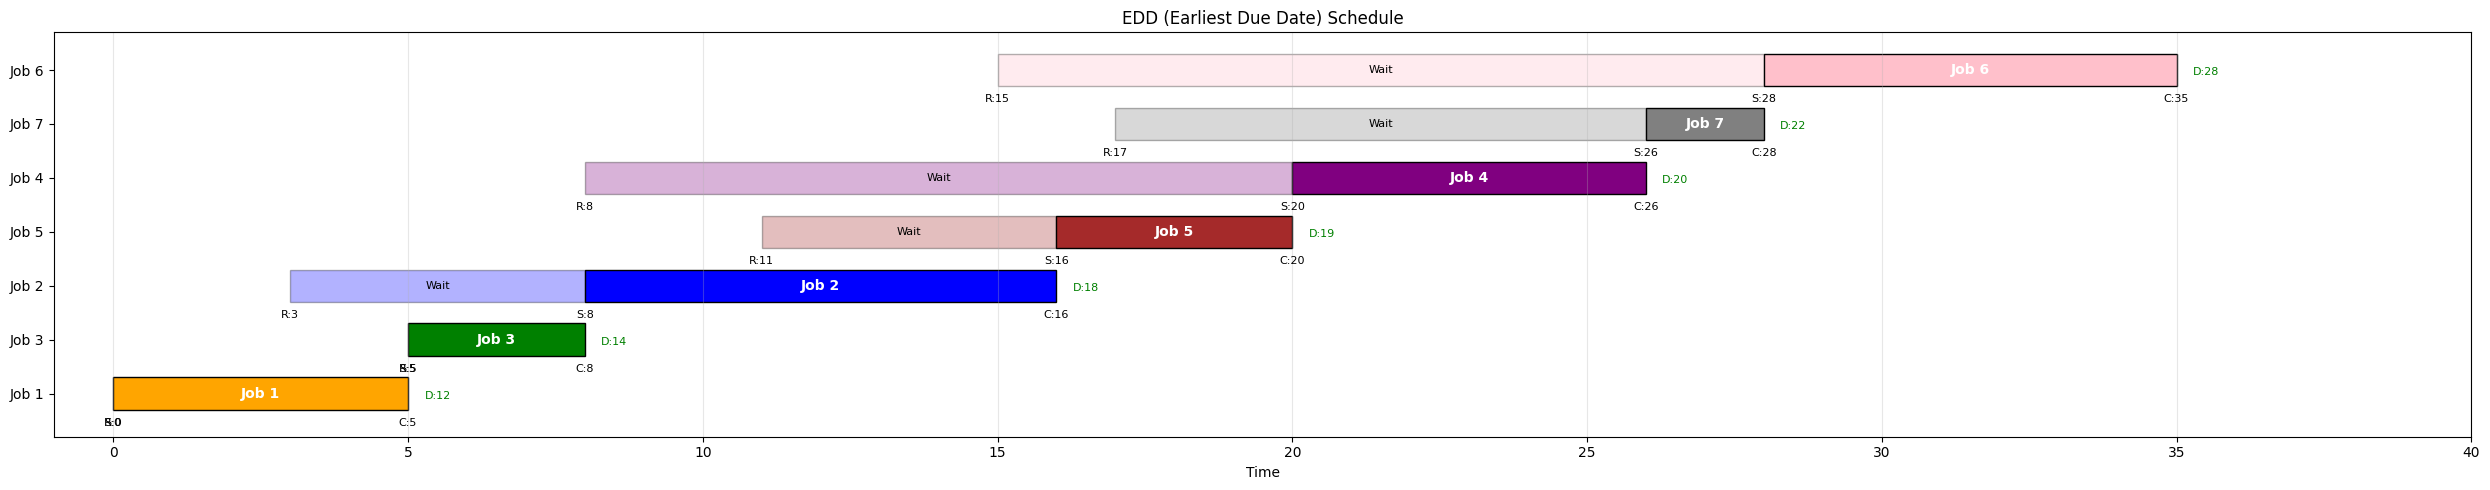

In [33]:
# POPULAR DISPATCHING RULES: EDD
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd

def EDD(jobs_df):
    # Make a copy (sorting by the increasing due_date)
    df = jobs_df.copy().sort_values('Due_Date')

    # Initialize variables
    current_time = 0
    start_times = []
    completion_times = []
    waiting_times = []
    flow_times = []
    lateness_values = []
    tardiness_values = []

    # Process each job in the order they appear
    for idx, job in df.iterrows():
        # Update current time (job can't start before its release date)
        current_time = max(current_time, job['Release_Date'])

        # Calculate start time for this job
        start_time = current_time
        start_times.append(start_time)

        # Process the job
        current_time += job['Processing_Time']
        completion_time = current_time
        completion_times.append(completion_time)

        # Calculate metrics
        waiting_time = start_time - job['Release_Date']
        flow_time = completion_time - job['Release_Date']
        lateness = completion_time - job['Due_Date']
        tardiness = max(0, completion_time - job['Due_Date'])

        # Save results
        waiting_times.append(waiting_time)
        flow_times.append(flow_time)
        lateness_values.append(lateness)
        tardiness_values.append(tardiness)

    # Add results to the dataframe
    df['Start_Time'] = start_times
    df['Completion_Time'] = completion_times
    df['Wait_Time'] = waiting_times
    df['Flow_Time'] = flow_times
    df['Lateness'] = lateness_values
    df['Tardiness'] = tardiness_values

    # Calculate total and average metrics
    total_completion_time = sum(completion_times)
    avg_completion_time = round(total_completion_time / len(jobs_df), 2)
    total_waiting_time = sum(waiting_times)
    avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
    total_flow_time = sum(flow_times)
    avg_flow_time = round(total_flow_time / len(jobs_df), 2)
    total_lateness = sum(lateness_values)
    avg_lateness = round(total_lateness / len(jobs_df), 2)
    total_tardiness = sum(tardiness_values)
    avg_tardiness = round(total_tardiness / len(jobs_df), 2)
    max_tardiness = max(tardiness_values)
    makespan = max(completion_times)

    # Calculate other metrics
    total_processing_time = sum(df['Processing_Time'])
    utilization = round((total_processing_time / total_flow_time) * 100, 2)  # in percentage
    avg_jobs_in_system = round(total_flow_time / total_processing_time, 2)
    num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

    # Weighted metrics (make sure 'Weight' column exists)
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default weight of 1 if not provided

    weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
    weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
    weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
    weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

    sum_weighted_completion = sum(weighted_completion_times)
    sum_weighted_flow = sum(weighted_flow_times)
    sum_weighted_wait = sum(weighted_wait_times)
    sum_weighted_tardiness = sum(weighted_tardiness)

    # Print results
    print("\nEDD Schedule Results:")
    print(f"Job sequence: {df['Job_ID'].tolist()}")
    print(f"Makespan (total completion time): {makespan}")

    # Create a results table for all individual job metrics
    results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                        'Flow_Time', 'Lateness', 'Tardiness']]
    print("\nDetailed Job Metrics:")
    print(results_table)

    # Create a summary table with averages
    summary_data = {
        'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
        'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
        'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
        'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
    }
    summary_table = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_table)

    # Create additional metrics table
    additional_metrics = {
        'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                  'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
        'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                 sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
    }
    additional_table = pd.DataFrame(additional_metrics)
    print("\nAdditional Metrics:")
    print(additional_table)

    # Visualize the schedule
    visualize_edd_schedule(df)

    return df, results_table, summary_table, additional_table

def visualize_edd_schedule(df):
    """Visualize the EDD schedule with a Gantt chart"""
    # Set up the figure
    fig, ax = plt.subplots(figsize=(25, 5))

    # Define colors for jobs
    colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    y_position = 0
    y_ticks = []
    y_labels = []

    # Draw jobs in EDD order
    for idx, job in df.iterrows():
        job_id = int(job['Job_ID'])
        release_time = job['Release_Date']
        start_time = job['Start_Time']
        duration = job['Processing_Time']
        completion_time = job['Completion_Time']
        due_date = job['Due_Date']

        # Choose color based on job index
        color = colors[job_id % len(colors)]

        # Draw waiting time (lighter shade)
        if start_time > release_time:
            waiting_rect = patches.Rectangle(
                (release_time, y_position),
                start_time - release_time,
                0.6,
                linewidth=1,
                edgecolor='black',
                facecolor=color,
                alpha=0.3
            )
            ax.add_patch(waiting_rect)
            ax.text(
                release_time + (start_time - release_time)/2,
                y_position + 0.3,
                'Wait',
                ha='center',
                va='center',
                fontsize=8
            )

        # Draw processing time (full color)
        process_rect = patches.Rectangle(
            (start_time, y_position),
            duration,
            0.6,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(process_rect)

        # Add job ID text in the center of the rectangle
        ax.text(
            start_time + duration/2,
            y_position + 0.3,
            f"Job {job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Add time markers
        ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
        ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

        # Next job position
        y_position += 1
        y_ticks.append(y_position - 0.7)
        y_labels.append(f"Job {job_id}")

    # Set up the axis
    max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
    ax.set_xlim(-1, max_time)
    ax.set_ylim(-0.5, y_position)

    # Add time markers
    time_ticks = np.arange(0, max_time + 5, 5)
    ax.set_xticks(time_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_title('EDD (Earliest Due Date) Schedule')

    plt.tight_layout()
    plt.show()

# Example usage:
edd_results, metrics_table, summary_table, additional_table = EDD(df)


ERD Schedule Results:
Job sequence: [1, 2, 3, 4, 5, 6, 7]
Makespan (total completion time): 35

Detailed Job Metrics:
   Job_ID  Start_Time  Completion_Time  Wait_Time  Flow_Time  Lateness  \
0       1           0                5          0          5        -7   
1       2           5               13          2         10        -5   
2       3          13               16          8         11         2   
3       4          16               22          8         14         2   
4       5          22               26         11         15         7   
5       6          26               33         11         18         5   
6       7          33               35         16         18        13   

   Tardiness  
0          0  
1          0  
2          2  
3          2  
4          7  
5          5  
6         13  

Summary Statistics:
            Metric  Total  Average  Maximum
0  Completion Time    150    21.43       35
1        Wait Time     56     8.00       16
2        Flow T

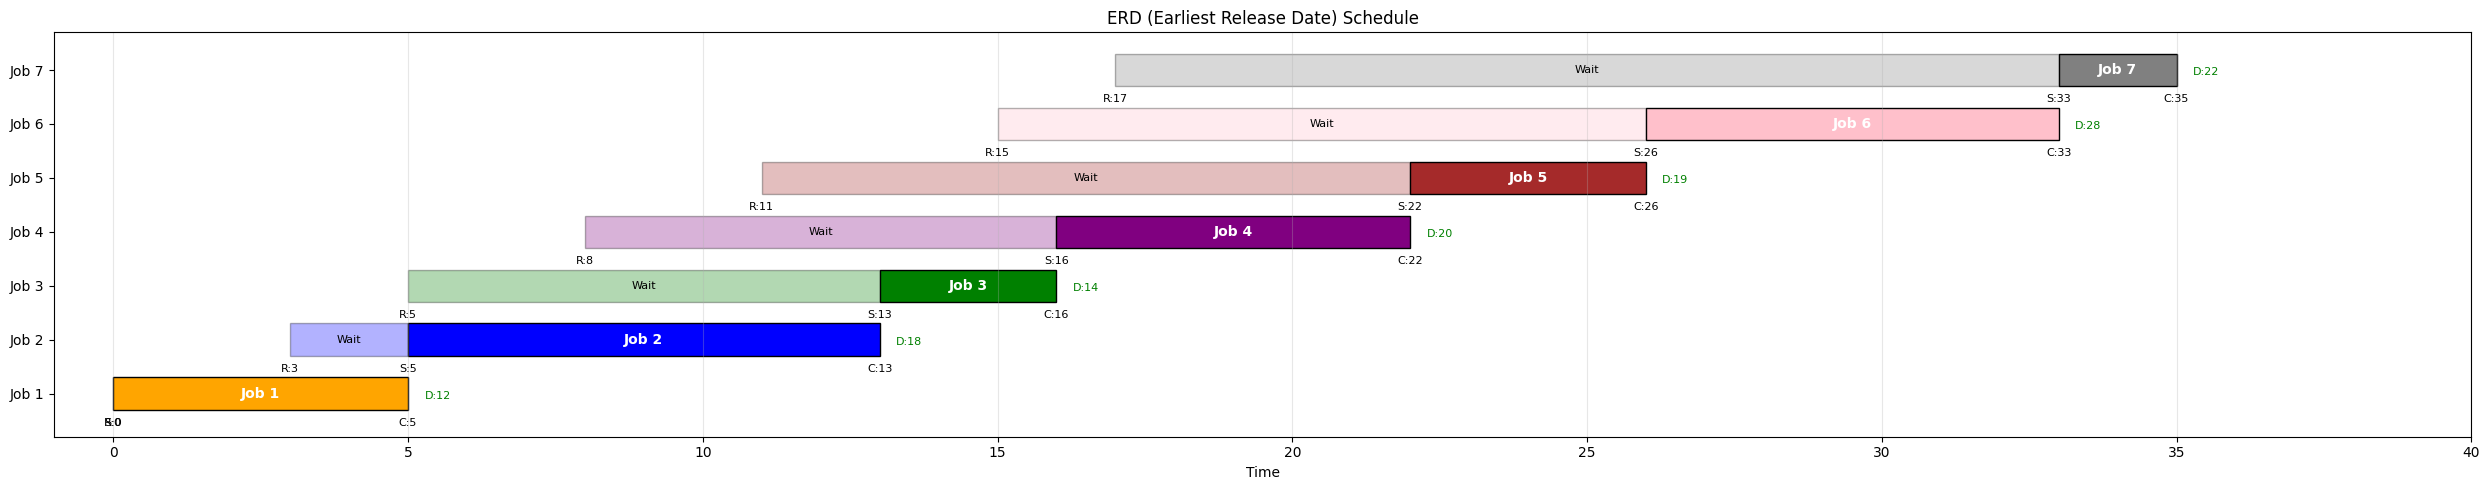

In [34]:
# POPULAR DISPATCHING RULES: ERD
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd

def ERD(jobs_df):
    # Make a copy (sorting by the increasing realease_date)
    df = jobs_df.copy().sort_values('Release_Date')

    # Initialize variables
    current_time = 0
    start_times = []
    completion_times = []
    waiting_times = []
    flow_times = []
    lateness_values = []
    tardiness_values = []

    # Process each job in the order they appear
    for idx, job in df.iterrows():
        # Update current time (job can't start before its release date)
        current_time = max(current_time, job['Release_Date'])

        # Calculate start time for this job
        start_time = current_time
        start_times.append(start_time)

        # Process the job
        current_time += job['Processing_Time']
        completion_time = current_time
        completion_times.append(completion_time)

        # Calculate metrics
        waiting_time = start_time - job['Release_Date']
        flow_time = completion_time - job['Release_Date']
        lateness = completion_time - job['Due_Date']
        tardiness = max(0, completion_time - job['Due_Date'])

        # Save results
        waiting_times.append(waiting_time)
        flow_times.append(flow_time)
        lateness_values.append(lateness)
        tardiness_values.append(tardiness)

    # Add results to the dataframe
    df['Start_Time'] = start_times
    df['Completion_Time'] = completion_times
    df['Wait_Time'] = waiting_times
    df['Flow_Time'] = flow_times
    df['Lateness'] = lateness_values
    df['Tardiness'] = tardiness_values

    # Calculate total and average metrics
    total_completion_time = sum(completion_times)
    avg_completion_time = round(total_completion_time / len(jobs_df), 2)
    total_waiting_time = sum(waiting_times)
    avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
    total_flow_time = sum(flow_times)
    avg_flow_time = round(total_flow_time / len(jobs_df), 2)
    total_lateness = sum(lateness_values)
    avg_lateness = round(total_lateness / len(jobs_df), 2)
    total_tardiness = sum(tardiness_values)
    avg_tardiness = round(total_tardiness / len(jobs_df), 2)
    max_tardiness = max(tardiness_values)
    makespan = max(completion_times)

    # Calculate other metrics
    total_processing_time = sum(df['Processing_Time'])
    utilization = round((total_processing_time / total_flow_time) * 100, 2)  # in percentage
    avg_jobs_in_system = round(total_flow_time / total_processing_time, 2)
    num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

    # Weighted metrics (make sure 'Weight' column exists)
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default weight of 1 if not provided

    weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
    weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
    weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
    weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

    sum_weighted_completion = sum(weighted_completion_times)
    sum_weighted_flow = sum(weighted_flow_times)
    sum_weighted_wait = sum(weighted_wait_times)
    sum_weighted_tardiness = sum(weighted_tardiness)

    # Print results
    print("\nERD Schedule Results:")
    print(f"Job sequence: {df['Job_ID'].tolist()}")
    print(f"Makespan (total completion time): {makespan}")

    # Create a results table for all individual job metrics
    results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                        'Flow_Time', 'Lateness', 'Tardiness']]
    print("\nDetailed Job Metrics:")
    print(results_table)

    # Create a summary table with averages
    summary_data = {
        'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
        'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
        'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
        'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
    }
    summary_table = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_table)

    # Create additional metrics table
    additional_metrics = {
        'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                  'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
        'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                 sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
    }
    additional_table = pd.DataFrame(additional_metrics)
    print("\nAdditional Metrics:")
    print(additional_table)

    # Visualize the schedule
    visualize_erd_schedule(df)

    return df, results_table, summary_table, additional_table

def visualize_erd_schedule(df):
    """Visualize the ERD schedule with a Gantt chart"""
    # Set up the figure
    fig, ax = plt.subplots(figsize=(25, 5))

    # Define colors for jobs
    colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    y_position = 0
    y_ticks = []
    y_labels = []

    # Draw jobs in ERD order
    for idx, job in df.iterrows():
        job_id = int(job['Job_ID'])
        release_time = job['Release_Date']
        start_time = job['Start_Time']
        duration = job['Processing_Time']
        completion_time = job['Completion_Time']
        due_date = job['Due_Date']

        # Choose color based on job index
        color = colors[job_id % len(colors)]

        # Draw waiting time (lighter shade)
        if start_time > release_time:
            waiting_rect = patches.Rectangle(
                (release_time, y_position),
                start_time - release_time,
                0.6,
                linewidth=1,
                edgecolor='black',
                facecolor=color,
                alpha=0.3
            )
            ax.add_patch(waiting_rect)
            ax.text(
                release_time + (start_time - release_time)/2,
                y_position + 0.3,
                'Wait',
                ha='center',
                va='center',
                fontsize=8
            )

        # Draw processing time (full color)
        process_rect = patches.Rectangle(
            (start_time, y_position),
            duration,
            0.6,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(process_rect)

        # Add job ID text in the center of the rectangle
        ax.text(
            start_time + duration/2,
            y_position + 0.3,
            f"Job {job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Add time markers
        ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
        ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

        # Next job position
        y_position += 1
        y_ticks.append(y_position - 0.7)
        y_labels.append(f"Job {job_id}")

    # Set up the axis
    max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
    ax.set_xlim(-1, max_time)
    ax.set_ylim(-0.5, y_position)

    # Add time markers
    time_ticks = np.arange(0, max_time + 5, 5)
    ax.set_xticks(time_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_title('ERD (Earliest Release Date) Schedule')

    plt.tight_layout()
    plt.show()

# Example usage:
erd_results, metrics_table, summary_table, additional_table = ERD(df)


WSPT Schedule Results:
Job sequence: [7, 3, 5, 1, 2, 4, 6]
Makespan (total completion time): 52.0

Detailed Job Metrics:
   Job_ID  pj/wj  Start_Time  Completion_Time  Wait_Time  Flow_Time  Lateness  \
6       7   0.50        17.0             19.0        0.0        2.0      -3.0   
2       3   0.60        19.0             22.0       14.0       17.0       8.0   
4       5   1.33        22.0             26.0       11.0       15.0       7.0   
0       1   1.67        26.0             31.0       26.0       31.0      19.0   
1       2   2.00        31.0             39.0       28.0       36.0      21.0   
3       4   3.00        39.0             45.0       31.0       37.0      25.0   
5       6   7.00        45.0             52.0       30.0       37.0      24.0   

   Tardiness  
6        0.0  
2        8.0  
4        7.0  
0       19.0  
1       21.0  
3       25.0  
5       24.0  

Summary Statistics:
            Metric  Total  Average  Maximum
0  Completion Time  234.0    33.43     52.0


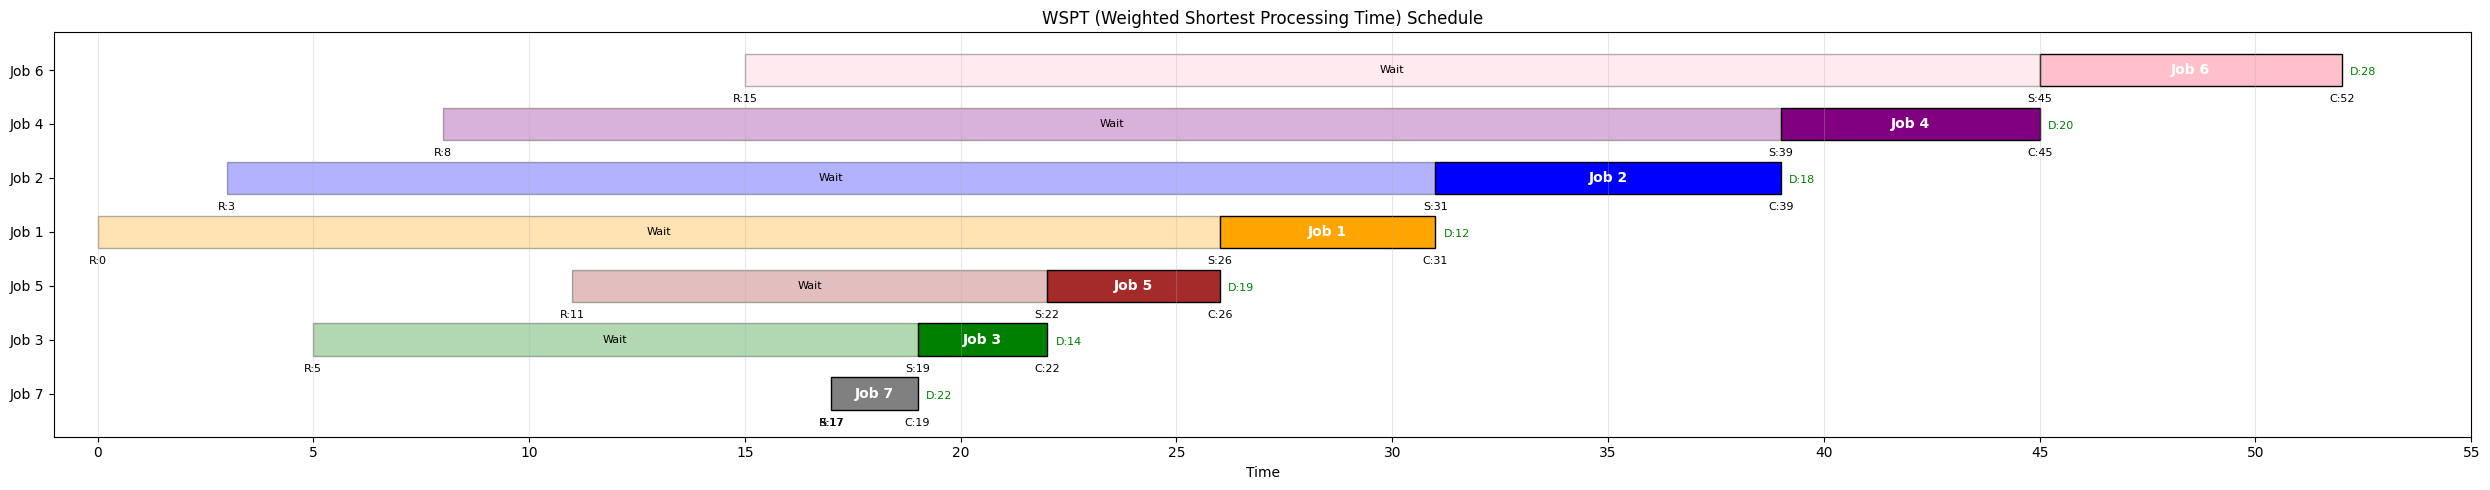

In [36]:
# POPULAR DISPATCHING RULES: WSPT
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd
df1 = df.copy()
df1['pj/wj'] = round(df1['Processing_Time']/df1['Weight'], 2)

def WSPT(jobs_df):
    # Make a copy (sorting by the increasing realease_date)
    df = jobs_df.copy().sort_values('pj/wj')

    # Initialize variables
    current_time = 0
    start_times = []
    completion_times = []
    waiting_times = []
    flow_times = []
    lateness_values = []
    tardiness_values = []

    # Process each job in the order they appear
    for idx, job in df.iterrows():
        # Update current time (job can't start before its release date)
        current_time = max(current_time, job['Release_Date'])

        # Calculate start time for this job
        start_time = current_time
        start_times.append(start_time)

        # Process the job
        current_time += job['Processing_Time']
        completion_time = current_time
        completion_times.append(completion_time)

        # Calculate metrics
        waiting_time = start_time - job['Release_Date']
        flow_time = completion_time - job['Release_Date']
        lateness = completion_time - job['Due_Date']
        tardiness = max(0, completion_time - job['Due_Date'])

        # Save results
        waiting_times.append(waiting_time)
        flow_times.append(flow_time)
        lateness_values.append(lateness)
        tardiness_values.append(tardiness)

    # Add results to the dataframe
    df['Start_Time'] = start_times
    df['Completion_Time'] = completion_times
    df['Wait_Time'] = waiting_times
    df['Flow_Time'] = flow_times
    df['Lateness'] = lateness_values
    df['Tardiness'] = tardiness_values

    # Calculate total and average metrics
    total_completion_time = sum(completion_times)
    avg_completion_time = round(total_completion_time / len(jobs_df), 2)
    total_waiting_time = sum(waiting_times)
    avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
    total_flow_time = sum(flow_times)
    avg_flow_time = round(total_flow_time / len(jobs_df), 2)
    total_lateness = sum(lateness_values)
    avg_lateness = round(total_lateness / len(jobs_df), 2)
    total_tardiness = sum(tardiness_values)
    avg_tardiness = round(total_tardiness / len(jobs_df), 2)
    max_tardiness = max(tardiness_values)
    makespan = max(completion_times)

    # Calculate other metrics
    total_processing_time = sum(df['Processing_Time'])
    utilization = round((total_processing_time / total_flow_time) * 100, 2)  # in percentage
    avg_jobs_in_system = round(total_flow_time / total_processing_time, 2)
    num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

    # Weighted metrics (make sure 'Weight' column exists)
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default weight of 1 if not provided

    weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
    weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
    weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
    weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

    sum_weighted_completion = sum(weighted_completion_times)
    sum_weighted_flow = sum(weighted_flow_times)
    sum_weighted_wait = sum(weighted_wait_times)
    sum_weighted_tardiness = sum(weighted_tardiness)

    # Print results
    print("\nWSPT Schedule Results:")
    print(f"Job sequence: {df['Job_ID'].tolist()}")
    print(f"Makespan (total completion time): {makespan}")

    # Create a results table for all individual job metrics
    results_table = df[['Job_ID', 'pj/wj','Start_Time', 'Completion_Time', 'Wait_Time',
                        'Flow_Time', 'Lateness', 'Tardiness']]
    print("\nDetailed Job Metrics:")
    print(results_table)

    # Create a summary table with averages
    summary_data = {
        'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
        'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
        'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
        'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
    }
    summary_table = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_table)

    # Create additional metrics table
    additional_metrics = {
        'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                  'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
        'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                 sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
    }
    additional_table = pd.DataFrame(additional_metrics)
    print("\nAdditional Metrics:")
    print(additional_table)

    # Visualize the schedule
    visualize_wspt_schedule(df)

    return df, results_table, summary_table, additional_table

def visualize_wspt_schedule(df):
    """Visualize the WSPT schedule with a Gantt chart"""
    # Set up the figure
    fig, ax = plt.subplots(figsize=(25, 5))

    # Define colors for jobs
    colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    y_position = 0
    y_ticks = []
    y_labels = []

    # Draw jobs in WSPT order
    for idx, job in df.iterrows():
        job_id = int(job['Job_ID'])
        release_time = job['Release_Date']
        start_time = job['Start_Time']
        duration = job['Processing_Time']
        completion_time = job['Completion_Time']
        due_date = job['Due_Date']

        # Choose color based on job index
        color = colors[job_id % len(colors)]

        # Draw waiting time (lighter shade)
        if start_time > release_time:
            waiting_rect = patches.Rectangle(
                (release_time, y_position),
                start_time - release_time,
                0.6,
                linewidth=1,
                edgecolor='black',
                facecolor=color,
                alpha=0.3
            )
            ax.add_patch(waiting_rect)
            ax.text(
                release_time + (start_time - release_time)/2,
                y_position + 0.3,
                'Wait',
                ha='center',
                va='center',
                fontsize=8
            )

        # Draw processing time (full color)
        process_rect = patches.Rectangle(
            (start_time, y_position),
            duration,
            0.6,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(process_rect)

        # Add job ID text in the center of the rectangle
        ax.text(
            start_time + duration/2,
            y_position + 0.3,
            f"Job {job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Add time markers
        ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
        ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

        # Next job position
        y_position += 1
        y_ticks.append(y_position - 0.7)
        y_labels.append(f"Job {job_id}")

    # Set up the axis
    max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
    ax.set_xlim(-1, max_time)
    ax.set_ylim(-0.5, y_position)

    # Add time markers
    time_ticks = np.arange(0, max_time + 5, 5)
    ax.set_xticks(time_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_title('WSPT (Weighted Shortest Processing Time) Schedule')

    plt.tight_layout()
    plt.show()

# Example usage:
wspt_results, metrics_table, summary_table, additional_table = WSPT(df1)


RAND Schedule Results:
Job sequence: [3, 5, 7, 1, 2, 6, 4]
Makespan (total completion time): 45

Detailed Job Metrics:
   Job_ID  Start_Time  Completion_Time  Wait_Time  Flow_Time  Lateness  \
0       3           5                8          0          3        -6   
1       5          11               15          0          4        -4   
2       7          17               19          0          2        -3   
3       1          19               24         19         24        12   
4       2          24               32         21         29        14   
5       6          32               39         17         24        11   
6       4          39               45         31         37        25   

   Tardiness  
0          0  
1          0  
2          0  
3         12  
4         14  
5         11  
6         25  

Summary Statistics:
            Metric  Total  Average  Maximum
0  Completion Time    182    26.00       45
1        Wait Time     88    12.57       31
2        Flow 

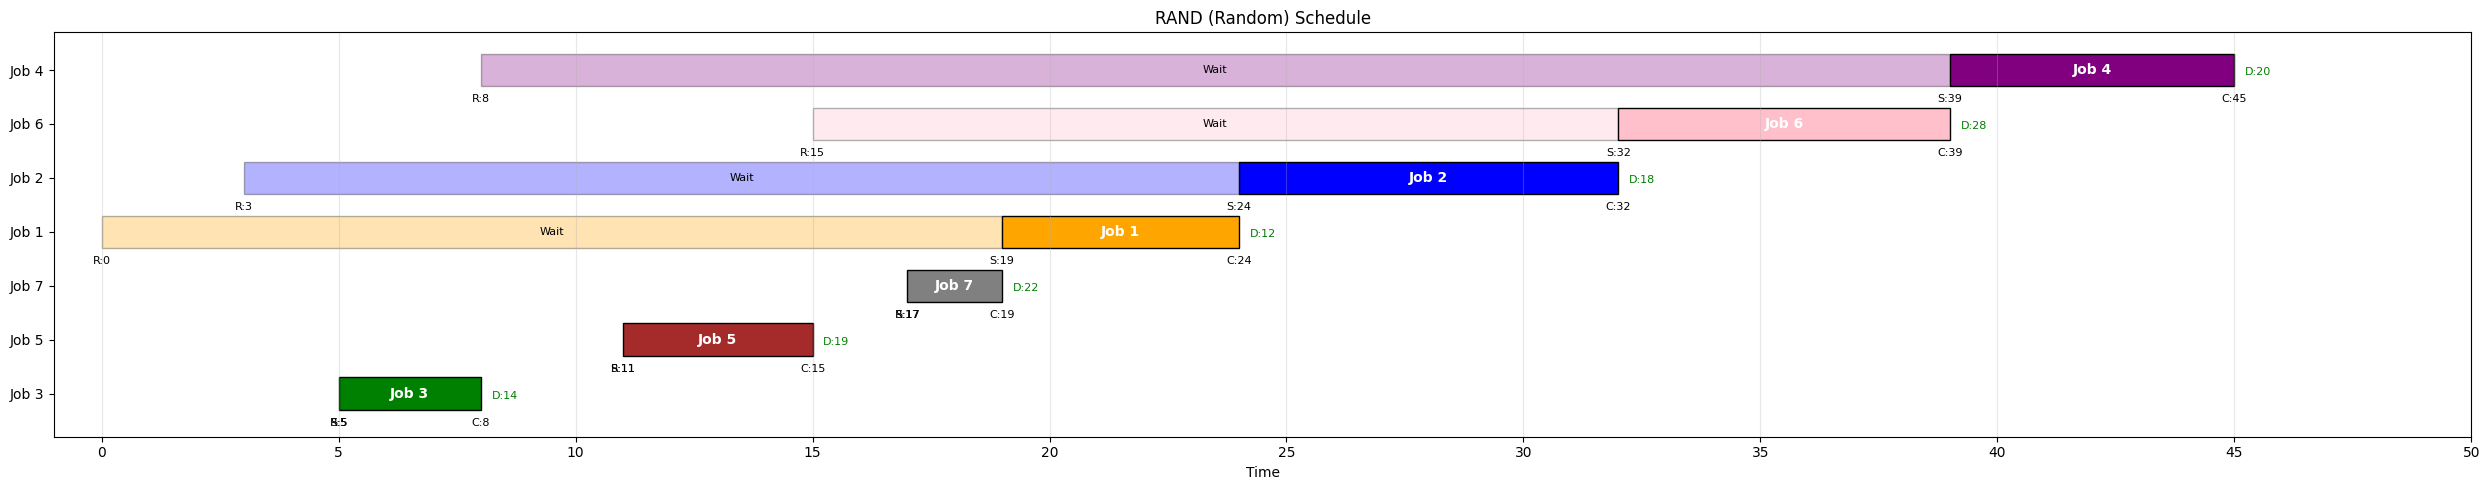

In [41]:
# POPULAR DISPATCHING RULES: RAND
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd

def RAND(jobs_df):
    # Make a copy (sorting by the increasing realease_date)
    df = jobs_df.sample(frac=1).reset_index(drop=True)

    # Initialize variables
    current_time = 0
    start_times = []
    completion_times = []
    waiting_times = []
    flow_times = []
    lateness_values = []
    tardiness_values = []

    # Process each job in the order they appear
    for idx, job in df.iterrows():
        # Update current time (job can't start before its release date)
        current_time = max(current_time, job['Release_Date'])

        # Calculate start time for this job
        start_time = current_time
        start_times.append(start_time)

        # Process the job
        current_time += job['Processing_Time']
        completion_time = current_time
        completion_times.append(completion_time)

        # Calculate metrics
        waiting_time = start_time - job['Release_Date']
        flow_time = completion_time - job['Release_Date']
        lateness = completion_time - job['Due_Date']
        tardiness = max(0, completion_time - job['Due_Date'])

        # Save results
        waiting_times.append(waiting_time)
        flow_times.append(flow_time)
        lateness_values.append(lateness)
        tardiness_values.append(tardiness)

    # Add results to the dataframe
    df['Start_Time'] = start_times
    df['Completion_Time'] = completion_times
    df['Wait_Time'] = waiting_times
    df['Flow_Time'] = flow_times
    df['Lateness'] = lateness_values
    df['Tardiness'] = tardiness_values

    # Calculate total and average metrics
    total_completion_time = sum(completion_times)
    avg_completion_time = round(total_completion_time / len(jobs_df), 2)
    total_waiting_time = sum(waiting_times)
    avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
    total_flow_time = sum(flow_times)
    avg_flow_time = round(total_flow_time / len(jobs_df), 2)
    total_lateness = sum(lateness_values)
    avg_lateness = round(total_lateness / len(jobs_df), 2)
    total_tardiness = sum(tardiness_values)
    avg_tardiness = round(total_tardiness / len(jobs_df), 2)
    max_tardiness = max(tardiness_values)
    makespan = max(completion_times)

    # Calculate other metrics
    total_processing_time = sum(df['Processing_Time'])
    utilization = round((total_processing_time / total_flow_time) * 100, 2)  # in percentage
    avg_jobs_in_system = round(total_flow_time / total_processing_time, 2)
    num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

    # Weighted metrics (make sure 'Weight' column exists)
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default weight of 1 if not provided

    weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
    weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
    weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
    weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

    sum_weighted_completion = sum(weighted_completion_times)
    sum_weighted_flow = sum(weighted_flow_times)
    sum_weighted_wait = sum(weighted_wait_times)
    sum_weighted_tardiness = sum(weighted_tardiness)

    # Print results
    print("\nRAND Schedule Results:")
    print(f"Job sequence: {df['Job_ID'].tolist()}")
    print(f"Makespan (total completion time): {makespan}")

    # Create a results table for all individual job metrics
    results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                        'Flow_Time', 'Lateness', 'Tardiness']]
    print("\nDetailed Job Metrics:")
    print(results_table)

    # Create a summary table with averages
    summary_data = {
        'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
        'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
        'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
        'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
    }
    summary_table = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_table)

    # Create additional metrics table
    additional_metrics = {
        'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                  'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
        'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                 sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
    }
    additional_table = pd.DataFrame(additional_metrics)
    print("\nAdditional Metrics:")
    print(additional_table)

    # Visualize the schedule
    visualize_rand_schedule(df)

    return df, results_table, summary_table, additional_table

def visualize_rand_schedule(df):
    """Visualize the RAND schedule with a Gantt chart"""
    # Set up the figure
    fig, ax = plt.subplots(figsize=(25, 5))

    # Define colors for jobs
    colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    y_position = 0
    y_ticks = []
    y_labels = []

    # Draw jobs in RAND order
    for idx, job in df.iterrows():
        job_id = int(job['Job_ID'])
        release_time = job['Release_Date']
        start_time = job['Start_Time']
        duration = job['Processing_Time']
        completion_time = job['Completion_Time']
        due_date = job['Due_Date']

        # Choose color based on job index
        color = colors[job_id % len(colors)]

        # Draw waiting time (lighter shade)
        if start_time > release_time:
            waiting_rect = patches.Rectangle(
                (release_time, y_position),
                start_time - release_time,
                0.6,
                linewidth=1,
                edgecolor='black',
                facecolor=color,
                alpha=0.3
            )
            ax.add_patch(waiting_rect)
            ax.text(
                release_time + (start_time - release_time)/2,
                y_position + 0.3,
                'Wait',
                ha='center',
                va='center',
                fontsize=8
            )

        # Draw processing time (full color)
        process_rect = patches.Rectangle(
            (start_time, y_position),
            duration,
            0.6,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(process_rect)

        # Add job ID text in the center of the rectangle
        ax.text(
            start_time + duration/2,
            y_position + 0.3,
            f"Job {job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Add time markers
        ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
        ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
        ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

        # Next job position
        y_position += 1
        y_ticks.append(y_position - 0.7)
        y_labels.append(f"Job {job_id}")

    # Set up the axis
    max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
    ax.set_xlim(-1, max_time)
    ax.set_ylim(-0.5, y_position)

    # Add time markers
    time_ticks = np.arange(0, max_time + 5, 5)
    ax.set_xticks(time_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_title('RAND (Random) Schedule')

    plt.tight_layout()
    plt.show()

# Example usage:
rand_results, metrics_table, summary_table, additional_table = RAND(df)


Number of jobs completed on time: 6 [1, 3, 5, 4, 7, 6]

Number of late jobs (Objective value): 1 [2]


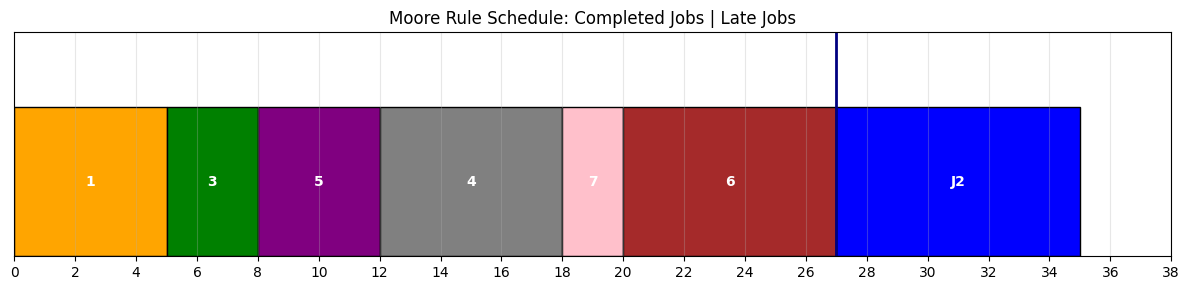

In [12]:
# Moore Rule - Earliest Due Date - Obj: Minimize the number of late jobs

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def moore_rule(jobs_df):
    # Make a copy and sort by due date (ascending)
    df = jobs_df.copy().sort_values('Due_Date')

    # Initialize variables
    current_time = 0
    scheduled_indices = []

    # Process each task in order of due date - First iteration: idx=0, task=Series({'job_id': '1', 'Release_Date': 0, ...})
    for idx, task in df.iterrows():
        # Add this task to our schedule
        scheduled_indices.append(idx)
        current_time += task['Processing_Time']

        # If we've missed the due date
        if current_time > task['Due_Date']:
            # Find and remove the task with the longest processing time
            longest_idx = max(
                [(i, df.loc[i, 'Processing_Time']) for i in scheduled_indices],
                key=lambda x: x[1]
            )[0]

            scheduled_indices.remove(longest_idx)
            current_time -= df.loc[longest_idx, 'Processing_Time']

    # Calculate late jobs (those not in scheduled_indices)
    all_indices = jobs_df.index.tolist()
    late_indices = [idx for idx in all_indices if idx not in scheduled_indices]

    # Print completed jobs
    print("\nNumber of jobs completed on time:", len(jobs_df.loc[scheduled_indices]), jobs_df.loc[scheduled_indices]['Job_ID'].tolist())

    # Print late jobs
    print("\nNumber of late jobs (Objective value):", len(jobs_df.loc[late_indices]), jobs_df.loc[late_indices]['Job_ID'].tolist())

    # Create visualization
    visualize_schedule(jobs_df, scheduled_indices, late_indices)

def visualize_schedule(jobs_df, completed_indices, late_indices):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 3))

    # Define colors for jobs (you can expand this list as needed)
    colors = ['red', 'orange', 'blue', 'green', 'gray', 'purple', 'brown', 'pink', 'cyan', 'magenta']

    # Start with completed jobs
    completed_jobs = jobs_df.loc[completed_indices].sort_values('Due_Date')

    current_time = 0
    y_position = 0

    # Draw completed jobs first (in sequence)
    for idx, job in completed_jobs.iterrows():
        job_id = job['Job_ID']
        duration = job['Processing_Time']

        # Choose color based on job index (cycling through colors if needed)
        color = colors[int(job_id) % len(colors)]

        # Create rectangle for the job
        rect = patches.Rectangle((current_time, y_position), duration, 1,
                                linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

        # Add job ID text in the center of the rectangle
        ax.text(current_time + duration/2, y_position + 0.5, str(job_id),
                color='white', fontweight='bold', ha='center', va='center')

        # Move time forward
        current_time += duration

    # Draw a vertical line at the end of completed jobs
    ax.axvline(x=current_time, color='navy', linestyle='-', linewidth=2)

    # Now draw late jobs arbitrarily after completed jobs
    late_jobs = jobs_df.loc[late_indices]

    for idx, job in late_jobs.iterrows():
        job_id = job['Job_ID']
        duration = job['Processing_Time']

        # Choose color based on job index
        color = colors[int(job_id) % len(colors)]

        # Create rectangle for the job
        rect = patches.Rectangle((current_time, y_position), duration, 1,
                                linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

        # Add job ID text in the center of the rectangle
        ax.text(current_time + duration/2, y_position + 0.5, f"J{job_id}",
                color='white', fontweight='bold', ha='center', va='center')

        # Move time forward
        current_time += duration

    # Set up the axis
    ax.set_xlim(0, current_time + 1)
    ax.set_ylim(0, 1.5)

    # Add time markers
    time_ticks = np.arange(0, current_time + 4, 2)
    ax.set_xticks(time_ticks)
    ax.set_yticks([])

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    plt.title('Moore Rule Schedule: Completed Jobs | Late Jobs')
    plt.tight_layout()
    plt.show()

# Run the algorithm with visualization
moore_rule(df)

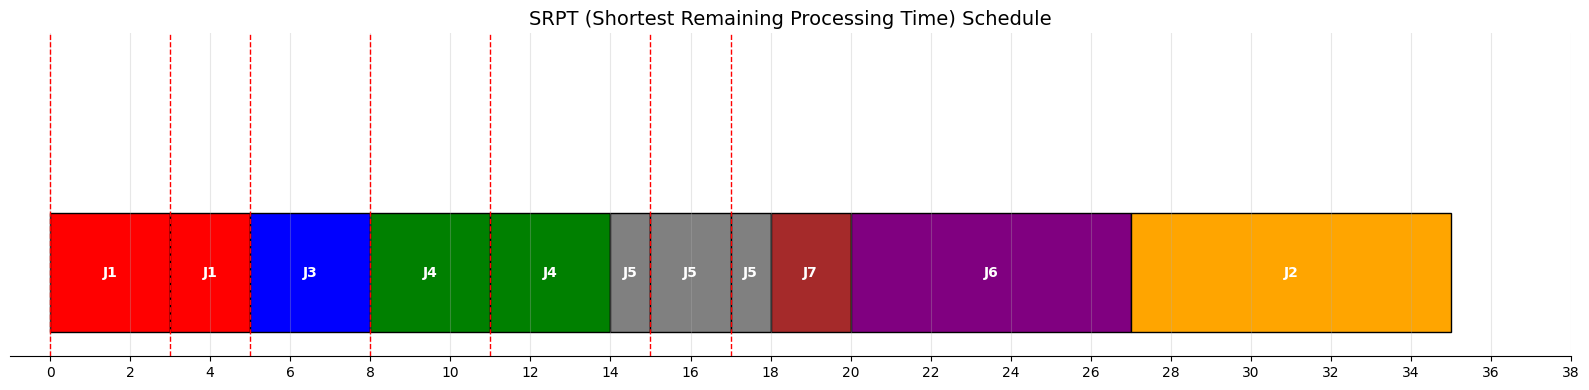

In [11]:
# SRPT (Shortest Remaining Processing Time) Algorithm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd

def SRPT(jobs_df):
    # Make a copy of the dataframe
    df = jobs_df.copy()

    # Create a column to track remaining processing time
    df['Remaining_Time'] = df['Processing_Time'].copy()

    # Sort by release date
    sorted_jobs = df.sort_values('Release_Date').reset_index(drop=True)

    # List to store execution timeline
    timeline = []

    # Keep track of current time and events
    current_time = sorted_jobs['Release_Date'].min()
    next_release_times = sorted_jobs['Release_Date'].tolist()
    next_release_times.sort()

    # Keep track of available and completed jobs
    available_jobs = []  # (job_id, remaining_time)
    completed_jobs = set()

    # Process until all jobs are completed
    while len(completed_jobs) < len(df):
        # Add any newly released jobs to available pool
        newly_released = sorted_jobs[(sorted_jobs['Release_Date'] <= current_time) &
                                    (~sorted_jobs['Job_ID'].isin([j[0] for j in available_jobs])) &
                                    (~sorted_jobs['Job_ID'].isin(completed_jobs))]

        for _, job in newly_released.iterrows():
            available_jobs.append((job['Job_ID'], job['Remaining_Time']))

        # If no available jobs, jump to next release time
        if not available_jobs:
            future_releases = [t for t in next_release_times if t > current_time]
            if future_releases:
                current_time = future_releases[0]
                continue
            else:
                break  # No more jobs to process

        # Find job with shortest remaining time
        available_jobs.sort(key=lambda x: x[1])  # Sort by remaining time
        current_job_id, current_job_remaining = available_jobs[0]

        # Determine how long to run this job
        # Find the next event (job completion or new release)
        next_release = min([t for t in next_release_times if t > current_time], default=float('inf'))
        job_completion_time = current_time + current_job_remaining

        # The next event is either job completion or next release, whichever comes first
        next_event_time = min(job_completion_time, next_release)
        duration = next_event_time - current_time

        # Execute the job for this duration
        timeline.append({
            'job_id': current_job_id,
            'start': current_time,
            'end': next_event_time
        })

        # Update remaining time
        job_index = sorted_jobs[sorted_jobs['Job_ID'] == current_job_id].index[0]
        sorted_jobs.loc[job_index, 'Remaining_Time'] -= duration

        # Update available jobs list
        if next_event_time == job_completion_time:
            # Job completed
            completed_jobs.add(current_job_id)
            available_jobs.pop(0)  # Remove this job
        else:
            # Job preempted, update its remaining time
            available_jobs[0] = (current_job_id, current_job_remaining - duration)

        # Advance time
        current_time = next_event_time

    # Visualize the timeline
    visualize_srpt_timeline(timeline, sorted_jobs['Release_Date'].tolist())

    return timeline

def visualize_srpt_timeline(timeline, release_dates):
    """Create a linear visualization of the SRPT schedule"""
    fig, ax = plt.subplots(figsize=(16, 4))

    # Define colors for jobs - more distinct colors
    colors = ['red', 'orange', 'blue', 'green', 'gray', 'purple', 'brown', 'pink', 'cyan', 'magenta']

    # Get max time for setting axis limits
    max_time = max(segment['end'] for segment in timeline)

    # Plot timeline segments
    for segment in timeline:
        start = segment['start']
        end = segment['end']
        job_id = segment['job_id']

        # Color by job ID (indexed from 1)
        color_idx = (job_id - 1) % len(colors)
        color = colors[color_idx]

        # Create rectangle for this job segment
        rect = patches.Rectangle(
            (start, 0),
            end - start,
            1,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(rect)

        # Add job ID text inside the rectangle
        ax.text(
            start + (end - start)/2,
            0.5,
            f"J{job_id}",
            color='white',
            fontweight='bold',
            ha='center',
            va='center',
            fontsize=10
        )

    # Identify preemption points and create flags
    job_segments = {}
    for segment in timeline:
        job_id = segment['job_id']
        if job_id not in job_segments:
            job_segments[job_id] = []
        job_segments[job_id].append((segment['start'], segment['end']))

    # Look for non-contiguous segments for each job
    for job_id, segments in job_segments.items():
        # Sort segments by start time
        segments.sort()

        # Check for preemptions (non-contiguous segments)
        for i in range(len(segments) - 1):
            if segments[i][1] != segments[i+1][0]:  # If end of segment != start of next segment
                preemption_time = segments[i][1]

                # Draw flag pole
                ax.plot([preemption_time, preemption_time], [1, 1.5], 'k-', linewidth=1.5)

                # Draw flag
                flag = patches.Rectangle(
                    (preemption_time, 1.5),
                    1.5,
                    0.5,
                    linewidth=1,
                    edgecolor='black',
                    facecolor='darkgreen'
                )
                ax.add_patch(flag)

                # Add job ID to flag
                ax.text(
                    preemption_time + 0.75,
                    1.75,
                    f"J{job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center',
                    fontsize=9
                )

    # Add release time markers (red dashed lines)
    for t in sorted(set(release_dates)):
        ax.axvline(x=t, color='red', linestyle='--', linewidth=1)

    # Set up the axis
    ax.set_xlim(-1, max_time + 3)
    ax.set_ylim(-0.2, 2.5)

    # Add time markers on x-axis
    time_range = np.arange(0, max_time + 4, 2)
    ax.set_xticks(time_range)
    ax.set_yticks([])

    # Add grid
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)

    # Remove y-axis
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add title
    ax.set_title('SRPT (Shortest Remaining Processing Time) Schedule', fontsize=14)

    plt.tight_layout()
    plt.show()

    return fig, ax

# Test with the example data
data = {
    'Job_ID': [1, 2, 3, 4, 5, 6, 7],
    'Release_Date': [0, 3, 5, 8, 11, 15, 17],
    'Processing_Time': [5, 8, 3, 6, 4, 7, 2],
    'Due_Date': [12, 18, 14, 20, 19, 28, 22],
    'Weight': [3, 4, 5, 2, 3, 1, 4]
}

df = pd.DataFrame(data)
timeline = SRPT(df)

Input data:
   Job_ID  Release_Date  Processing_Time  Due_Date  Weight
0       1             0                5        12       3
1       2             3                8        18       4
2       3             5                3        14       5
3       4             8                6        20       2
4       5            11                4        19       3
5       6            15                7        28       1
6       7            17                2        22       4

Optimal sequence: [1, 3, 2, 4, 5, 7, 6]
Minimum maximum lateness: 7
Computation time: 0.205 seconds
Path/Active nodes: 16
Terminal/End nodes: 29
Best nodes: 1


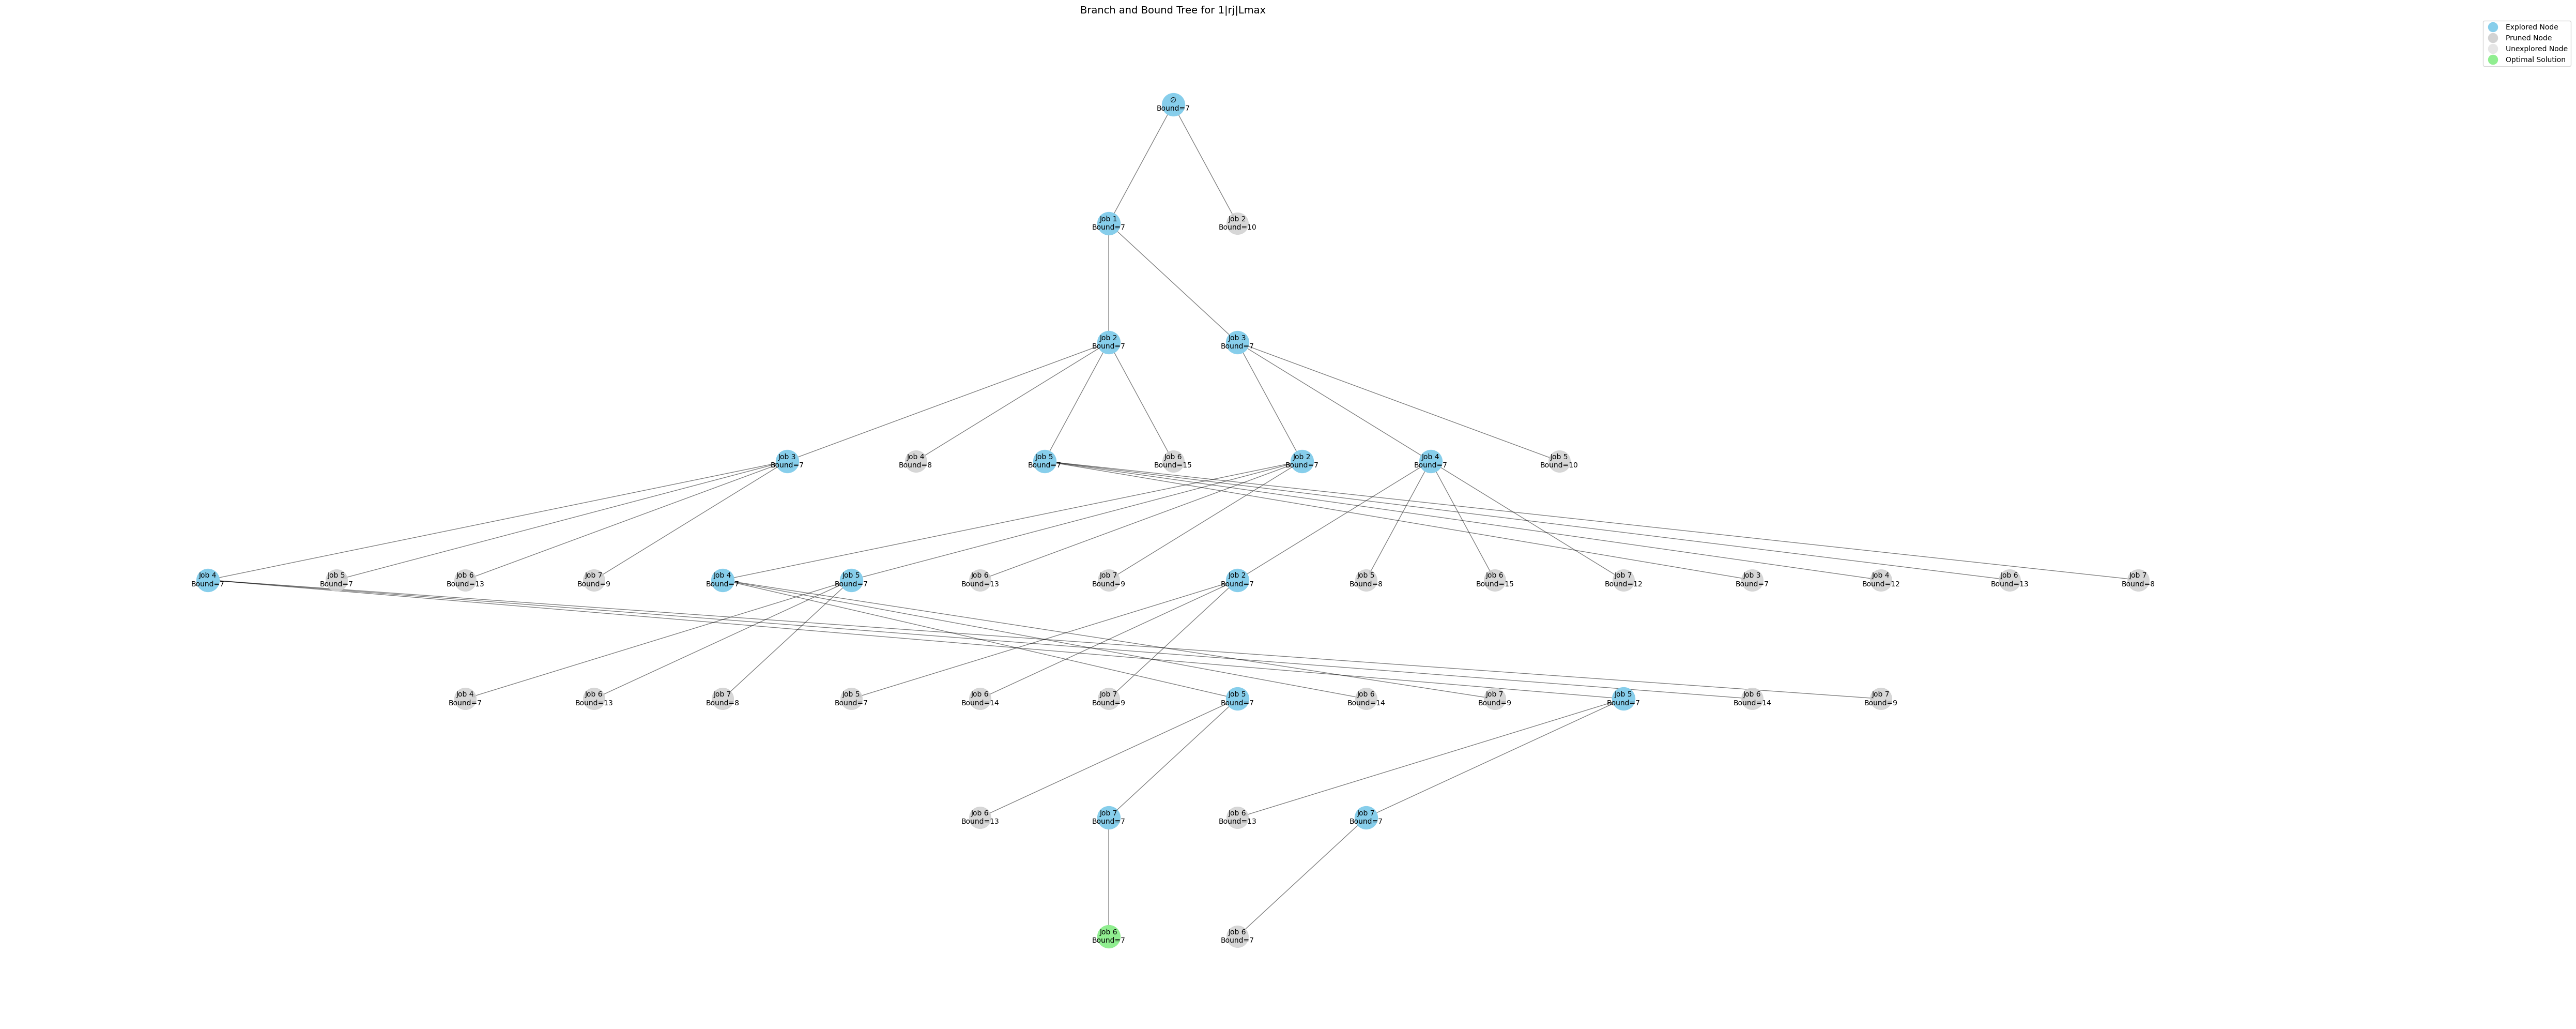

In [63]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import time

def branch_and_bound_lmax(jobs_df):
    """
    Branch and Bound algorithm for 1|rj|Lmax using preemptive EDD lower bound
    with tracking of explored nodes
    """
    # Create a copy of the dataframe
    df = jobs_df.copy().reset_index(drop=True)

    # Create a node class for the branch and bound tree
    class Node:
        def __init__(self, level, sequence, completion_time, lmax, parent=None):
            self.id = None  # Will be assigned during tree building
            self.level = level
            self.sequence = sequence.copy()
            self.completion_time = completion_time
            self.lmax = lmax  # Max lateness of the scheduled jobs
            self.parent = parent
            self.children = []
            self.pruned = False
            self.is_best = False
            self.bound = float('inf')  # Store the bound separately
            self.explored = False  # Track if the node was explored during search

        def __lt__(self, other):
            return self.bound < other.bound

    # Check dominance rule: rj < min_{l∈J} (max(t,rl) + pl)
    def is_dominated(job_id, unscheduled, current_time):
        job = df[df['Job_ID'] == job_id].iloc[0]
        r_j = job['Release_Date']

        for other_id in unscheduled:
            if other_id == job_id:
                continue

            other_job = df[df['Job_ID'] == other_id].iloc[0]
            r_l = other_job['Release_Date']
            p_l = other_job['Processing_Time']

            # Check dominance condition
            if r_j >= max(current_time, r_l) + p_l:
                return True

        return False

    # Calculate preemptive EDD lower bound
    def preemptive_edd_bound(scheduled, current_time):
        # Calculate max lateness of scheduled jobs
        scheduled_lateness = 0
        if scheduled:
            t = 0
            for job_id in scheduled:
                job = df[df['Job_ID'] == job_id].iloc[0]
                t = max(t, job['Release_Date']) + job['Processing_Time']
                lateness = t - job['Due_Date']
                scheduled_lateness = max(scheduled_lateness, lateness)

        # Get unscheduled jobs
        unscheduled = [j for j in df['Job_ID'] if j not in scheduled]
        if not unscheduled:
            return scheduled_lateness

        # Create job data for unscheduled jobs
        jobs = []
        for job_id in unscheduled:
            job = df[df['Job_ID'] == job_id].iloc[0]
            jobs.append({
                'id': job_id,
                'release': job['Release_Date'],
                'processing': job['Processing_Time'],
                'due': job['Due_Date'],
                'remaining': job['Processing_Time']
            })

        # Run preemptive EDD
        t = current_time
        lateness = scheduled_lateness

        while any(job['remaining'] > 0 for job in jobs):
            # Get available jobs
            available = [j for j in jobs if j['release'] <= t and j['remaining'] > 0]

            if not available:
                # Jump to next release time
                next_time = min(j['release'] for j in jobs if j['remaining'] > 0)
                t = next_time
                continue

            # Sort by EDD
            available.sort(key=lambda x: x['due'])

            # Process the job with earliest due date
            current_job = available[0]

            # Find the next event (release or completion)
            next_releases = [j['release'] for j in jobs if j['release'] > t and j['remaining'] > 0]

            if next_releases:
                next_event = min(next_releases)
                process_time = min(current_job['remaining'], next_event - t)
                current_job['remaining'] -= process_time
                t += process_time
            else:
                # No more releases, process to completion
                t += current_job['remaining']
                current_job['remaining'] = 0

            # Update lateness when a job completes
            if current_job['remaining'] == 0:
                job_lateness = t - current_job['due']
                lateness = max(lateness, job_lateness)

        return lateness

    # Create root node
    root = Node(level=0, sequence=[], completion_time=0, lmax=0)
    root.id = 0
    root.bound = preemptive_edd_bound([], 0)
    root.explored = True  # Root is always explored

    # Best solution found so far
    best_solution = None
    best_lmax = float('inf')

    # Use priority queue for best-first search
    queue = [root]
    heapq.heapify(queue)

    # Keep track of all nodes for visualization
    all_nodes = {0: root}
    next_id = 1

    # Start branch and bound
    while queue:
        current = heapq.heappop(queue)

        # Mark this node as explored (popped from queue)
        current.explored = True

        # Skip if already pruned
        if current.pruned:
            continue

        # If we've found a complete solution
        if current.level == len(df):
            if current.lmax < best_lmax:
                if best_solution:
                    best_solution.is_best = False
                best_lmax = current.lmax
                best_solution = current
                current.is_best = True

                # Important: Retrospectively prune nodes with bounds >= best_lmax
                for _, node in all_nodes.items():
                    if not node.is_best and node.bound >= best_lmax:
                        node.pruned = True
            continue

        # Get unscheduled jobs
        unscheduled = [j for j in df['Job_ID'] if j not in current.sequence]

        # Generate children according to dominance rule
        for job_id in unscheduled:
            if is_dominated(job_id, unscheduled, current.completion_time):
                continue

            # Get job info
            job = df[df['Job_ID'] == job_id].iloc[0]

            # Calculate completion time
            start_time = max(current.completion_time, job['Release_Date'])
            completion_time = start_time + job['Processing_Time']

            # Calculate maximum lateness of scheduled jobs
            lateness = completion_time - job['Due_Date']
            new_lmax = max(current.lmax, lateness)

            # Create new sequence
            new_sequence = current.sequence + [job_id]

            # Create child node
            child = Node(
                level=current.level + 1,
                sequence=new_sequence,
                completion_time=completion_time,
                lmax=new_lmax,
                parent=current
            )
            child.id = next_id
            next_id += 1

            # Add child to parent
            current.children.append(child)

            # Store for visualization
            all_nodes[child.id] = child

            # Calculate lower bound using preemptive EDD
            bound = preemptive_edd_bound(new_sequence, completion_time)
            child.bound = max(new_lmax, bound)  # Store the bound

            # Check if we can prune immediately
            if child.bound >= best_lmax:
                child.pruned = True
                continue

            # Add to queue
            heapq.heappush(queue, child)

    # Create a tree for visualization
    G = nx.DiGraph()

    # Add nodes
    for node_id, node in all_nodes.items():
        # Generate node label
        if node.level == 0:
            label = "∅"
        else:
            label = str(node.sequence[-1])

        # Add node with attributes
        G.add_node(
            node_id,
            level=node.level,
            sequence=node.sequence,
            lmax=node.bound,  # Use bound as the displayed value
            pruned=node.pruned,
            is_best=node.is_best,
            explored=node.explored,  # Include the explored flag
            label=label
        )

    # Add edges
    for node_id, node in all_nodes.items():
        for child in node.children:
            G.add_edge(node_id, child.id)

    # Return results
    if best_solution:
        return best_solution.sequence, best_lmax, G
    else:
        return None, float('inf'), G

def visualize_branch_bound_tree(G, fig_size=(50, 20)):
    """
    Improved Branch and Bound tree visualization showing exploration state
    """
    plt.figure(figsize=fig_size)

    # Get node levels
    levels = nx.get_node_attributes(G, 'level')
    max_level = max(levels.values())

    # Group nodes by level
    nodes_by_level = {}
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)

    # Calculate positions with improved spacing
    pos = {}
    h_space = 3.0  # Horizontal spacing factor
    v_space = 2.0  # Vertical spacing factor

    for level in range(max_level + 1):
        if level in nodes_by_level:
            nodes = sorted(nodes_by_level[level])
            width = len(nodes)

            # Apply spacing
            for i, node in enumerate(nodes):
                x = (i - width / 2 + 0.5) * h_space
                y = -level * v_space
                pos[node] = (x, y)

        # Identify different types of nodes - PATH-BASED CATEGORIZATION
    best_nodes = []           # Part of the best solution
    path_nodes = []           # Nodes that led to further exploration
    terminal_nodes = []       # Nodes that didn't lead anywhere (leaf nodes or pruned)

    for node in G.nodes():
        is_best = nx.get_node_attributes(G, 'is_best').get(node, False)

        if is_best:
            best_nodes.append(node)
            continue

        # Check if this node has children (successors)
        successors = list(G.successors(node))

        if successors:  # If node has children, it's part of the exploration path
            path_nodes.append(node)
        else:  # If no children, it's a terminal node
            terminal_nodes.append(node)

    # Debug info - print counts
    print(f"Path/Active nodes: {len(path_nodes)}")
    print(f"Terminal/End nodes: {len(terminal_nodes)}")
    print(f"Best nodes: {len(best_nodes)}")

    # Draw the graph in order

    # 1. Draw edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # 2. Draw terminal nodes
    if terminal_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=terminal_nodes,
                              node_color='lightgray',
                              node_size=900,
                              alpha=0.9)

    # 3. Draw path nodes
    if path_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=path_nodes,
                              node_color='skyblue',
                              node_size=1000,
                              alpha=1.0)

    # 4. Draw best solution nodes
    if best_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=best_nodes,
                              node_color='lightgreen',
                              node_size=1000,
                              alpha=1.0)

    # Get attributes for labels
    labels = nx.get_node_attributes(G, 'label')
    sequences = nx.get_node_attributes(G, 'sequence')
    lmaxes = nx.get_node_attributes(G, 'lmax')

    # Create custom labels with sequence and bound
    node_labels = {}
    for node in G.nodes():
        sequence = sequences[node]
        bound = lmaxes[node]
        job_label = labels[node]

        if len(sequence) == 0:
            node_labels[node] = f"∅\nBound={bound}"
        else:
            node_labels[node] = f"Job {job_label}\nBound={bound}"

    # 6. Draw labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

    # Add a legend with matching colors
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=15,
              label='Explored Node'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=15,
              label='Pruned Node'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e6e6e6', markersize=15,
              label='Unexplored Node'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15,
              label='Optimal Solution')
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1))

    # Add a title
    plt.title("Branch and Bound Tree for 1|rj|Lmax", fontsize=14)
    plt.axis('off')
    plt.tight_layout(pad=1.5)

    return plt.gcf()

# Example usage
print("Input data:")
print(df)

start_time = time.time()
optimal_sequence, optimal_lmax, tree = branch_and_bound_lmax(df)
end_time = time.time()

print(f"\nOptimal sequence: {optimal_sequence}")
print(f"Minimum maximum lateness: {optimal_lmax}")
print(f"Computation time: {end_time - start_time:.3f} seconds")

# Visualize the branch and bound tree
fig1 = visualize_branch_bound_tree(tree)
plt.figure(fig1.number)
plt.tight_layout()
plt.savefig('bnb_tree.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Install Streamlit: pip install streamlit
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import random
import time
import heapq
import networkx as nx
from matplotlib.lines import Line2D

# Set page title
st.title("Job Scheduling Algorithms")

# Sidebar for algorithm selection
st.sidebar.header("Select Algorithm")
algorithm = st.sidebar.selectbox(
    "Choose a scheduling algorithm",
    [
        "First Come First Serve (FCFS)",
        "Shortest Processing Time (SPT)",
        "Longest Processing Time (LPT)",
        "Earliest Due Date (EDD)",
        "Earliest Release Date (ERD)",
        "Weighted Shortest Processing Time (WSPT)",
        "Random Sequencing (RAND)",
        "Moore's Rule (Minimize Late Jobs)",
        "Shortest Remaining Processing Time (SRPT)",
        "Branch and Bound (Minimize Maximum Lateness)"
    ]
)

# Data input section
st.header("Input Job Data")
upload_option = st.radio("Choose input method:", ["Upload CSV/Excel", "Manual Input"])

df = None

if upload_option == "Upload CSV/Excel":
    uploaded_file = st.file_uploader("Upload job data file", type=["csv", "xlsx"])
    if uploaded_file is not None:
        if uploaded_file.name.endswith('.csv'):
            df = pd.read_csv(uploaded_file)
        else:
            df = pd.read_excel(uploaded_file)
        st.write("Uploaded data:")
        st.dataframe(df)
else:
    # Manual job input
    st.subheader("Enter job details")
    num_jobs = st.number_input("Number of jobs", min_value=1, max_value=20, value=3)

    job_data = {
        "Job_ID": [],
        "Processing_Time": [],
        "Due_Date": [],
        "Weight": [],
        "Release_Date": []
    }

    for i in range(num_jobs):
        st.markdown(f"**Job {i+1}**")
        cols = st.columns(5)

        job_data["Job_ID"].append(cols[0].number_input(f"Job ID {i+1}", value=i+1, key=f"id_{i}"))
        job_data["Processing_Time"].append(cols[1].number_input(f"Processing Time {i+1}", value=5, min_value=1, key=f"pt_{i}"))
        job_data["Due_Date"].append(cols[2].number_input(f"Due Date {i+1}", value=10, min_value=1, key=f"dd_{i}"))
        job_data["Weight"].append(cols[3].number_input(f"Weight {i+1}", value=1, min_value=1, key=f"w_{i}"))
        job_data["Release_Date"].append(cols[4].number_input(f"Release Date {i+1}", value=0, min_value=0, key=f"rd_{i}"))

    df = pd.DataFrame(job_data)
    st.write("Entered data:")
    st.dataframe(df)

# Run the algorithm
if df is not None and st.button("Run Algorithm"):
    # Check if Release_Date column exists, add if not
    if 'Release_Date' not in df.columns:
        df['Release_Date'] = 0  # Default to zero if not provided

    # Check if Weight column exists, add if not
    if 'Weight' not in df.columns:
        df['Weight'] = 1  # Default to one if not provided

    # 1. FCFS Algorithm
    if algorithm == "First Come First Serve (FCFS)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        # Define FCFS function
        def FCFS(jobs_df):
            # Make a copy (no sorting - take jobs in the order they appear)
            df = jobs_df.copy()

            # Initialize variables
            current_time = 0
            start_times = []
            completion_times = []
            waiting_times = []
            flow_times = []
            lateness_values = []
            tardiness_values = []

            # Process each job in the order they appear
            for idx, job in df.iterrows():
                # Update current time (job can't start before its release date)
                current_time = max(current_time, job['Release_Date'])

                # Calculate start time for this job
                start_time = current_time
                start_times.append(start_time)

                # Process the job
                current_time += job['Processing_Time']
                completion_time = current_time
                completion_times.append(completion_time)

                # Calculate metrics
                waiting_time = start_time - job['Release_Date']
                flow_time = completion_time - job['Release_Date']
                lateness = completion_time - job['Due_Date']
                tardiness = max(0, completion_time - job['Due_Date'])

                # Save results
                waiting_times.append(waiting_time)
                flow_times.append(flow_time)
                lateness_values.append(lateness)
                tardiness_values.append(tardiness)

            # Add results to the dataframe
            df['Start_Time'] = start_times
            df['Completion_Time'] = completion_times
            df['Wait_Time'] = waiting_times
            df['Flow_Time'] = flow_times
            df['Lateness'] = lateness_values
            df['Tardiness'] = tardiness_values

            # Calculate total and average metrics
            total_completion_time = sum(completion_times)
            avg_completion_time = round(total_completion_time / len(jobs_df), 2)
            total_waiting_time = sum(waiting_times)
            avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
            total_flow_time = sum(flow_times)
            avg_flow_time = round(total_flow_time / len(jobs_df), 2)
            total_lateness = sum(lateness_values)
            avg_lateness = round(total_lateness / len(jobs_df), 2)
            total_tardiness = sum(tardiness_values)
            avg_tardiness = round(total_tardiness / len(jobs_df), 2)
            max_tardiness = max(tardiness_values)
            makespan = max(completion_times)

            # Calculate other metrics
            total_processing_time = sum(df['Processing_Time'])
            utilization = round((total_processing_time / total_flow_time) * 100, 2) if total_flow_time > 0 else 0
            avg_jobs_in_system = round(total_flow_time / total_processing_time, 2) if total_processing_time > 0 else 0
            num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

            # Weighted metrics
            weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
            weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
            weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
            weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

            sum_weighted_completion = sum(weighted_completion_times)
            sum_weighted_flow = sum(weighted_flow_times)
            sum_weighted_wait = sum(weighted_wait_times)
            sum_weighted_tardiness = sum(weighted_tardiness)

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: FCFS")
                st.write(f"Job sequence: {df['Job_ID'].tolist()}")
                st.write(f"Makespan (total completion time): {makespan}")

                # Create a results table for all individual job metrics
                results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                                  'Flow_Time', 'Lateness', 'Tardiness']]
                st.subheader("Detailed Job Metrics:")
                st.dataframe(results_table)

                # Create a summary table with averages
                summary_data = {
                    'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
                    'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
                    'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
                    'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
                }
                summary_table = pd.DataFrame(summary_data)
                st.subheader("Summary Statistics:")
                st.dataframe(summary_table)

                # Create additional metrics table
                additional_metrics = {
                    'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                              'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
                    'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                             sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
                }
                additional_table = pd.DataFrame(additional_metrics)
                st.subheader("Additional Metrics:")
                st.dataframe(additional_table)

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_fcfs_schedule(df, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return df, results_table, summary_table, additional_table

        def visualize_fcfs_schedule(df, fig, ax):
            """Visualize the FCFS schedule with a Gantt chart"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

            y_position = 0
            y_ticks = []
            y_labels = []

            # Draw jobs in FCFS order
            for idx, job in df.iterrows():
                job_id = int(job['Job_ID'])
                release_time = job['Release_Date']
                start_time = job['Start_Time']
                duration = job['Processing_Time']
                completion_time = job['Completion_Time']
                due_date = job['Due_Date']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Draw waiting time (lighter shade)
                if start_time > release_time:
                    waiting_rect = patches.Rectangle(
                        (release_time, y_position),
                        start_time - release_time,
                        0.6,
                        linewidth=1,
                        edgecolor='black',
                        facecolor=color,
                        alpha=0.3
                    )
                    ax.add_patch(waiting_rect)
                    ax.text(
                        release_time + (start_time - release_time)/2,
                        y_position + 0.3,
                        'Wait',
                        ha='center',
                        va='center',
                        fontsize=8
                    )

                # Draw processing time (full color)
                process_rect = patches.Rectangle(
                    (start_time, y_position),
                    duration,
                    0.6,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(process_rect)

                # Add job ID text in the center of the rectangle
                ax.text(
                    start_time + duration/2,
                    y_position + 0.3,
                    f"Job {job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center'
                )

                # Add time markers
                ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
                ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

                # Next job position
                y_position += 1
                y_ticks.append(y_position - 0.7)
                y_labels.append(f"Job {job_id}")

            # Set up the axis
            max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
            ax.set_xlim(-1, max_time)
            ax.set_ylim(-0.5, y_position)

            # Add time markers
            time_ticks = np.arange(0, max_time + 5, 5)
            ax.set_xticks(time_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Add labels and title
            ax.set_xlabel('Time')
            ax.set_title('FCFS (First Come First Serve) Schedule')

            plt.tight_layout()

        # Run the algorithm
        FCFS(df)

    # 2. SPT Algorithm
    elif algorithm == "Shortest Processing Time (SPT)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        def SPT(jobs_df):
            # Make a copy (sorting by the increasing processing time)
            df = jobs_df.copy().sort_values('Processing_Time')

            # Initialize variables
            current_time = 0
            start_times = []
            completion_times = []
            waiting_times = []
            flow_times = []
            lateness_values = []
            tardiness_values = []

            # Process each job in the order they appear
            for idx, job in df.iterrows():
                # Update current time (job can't start before its release date)
                current_time = max(current_time, job['Release_Date'])

                # Calculate start time for this job
                start_time = current_time
                start_times.append(start_time)

                # Process the job
                current_time += job['Processing_Time']
                completion_time = current_time
                completion_times.append(completion_time)

                # Calculate metrics
                waiting_time = start_time - job['Release_Date']
                flow_time = completion_time - job['Release_Date']
                lateness = completion_time - job['Due_Date']
                tardiness = max(0, completion_time - job['Due_Date'])

                # Save results
                waiting_times.append(waiting_time)
                flow_times.append(flow_time)
                lateness_values.append(lateness)
                tardiness_values.append(tardiness)

            # Add results to the dataframe
            df['Start_Time'] = start_times
            df['Completion_Time'] = completion_times
            df['Wait_Time'] = waiting_times
            df['Flow_Time'] = flow_times
            df['Lateness'] = lateness_values
            df['Tardiness'] = tardiness_values

            # Calculate total and average metrics
            total_completion_time = sum(completion_times)
            avg_completion_time = round(total_completion_time / len(jobs_df), 2)
            total_waiting_time = sum(waiting_times)
            avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
            total_flow_time = sum(flow_times)
            avg_flow_time = round(total_flow_time / len(jobs_df), 2)
            total_lateness = sum(lateness_values)
            avg_lateness = round(total_lateness / len(jobs_df), 2)
            total_tardiness = sum(tardiness_values)
            avg_tardiness = round(total_tardiness / len(jobs_df), 2)
            max_tardiness = max(tardiness_values)
            makespan = max(completion_times)

            # Calculate other metrics
            total_processing_time = sum(df['Processing_Time'])
            utilization = round((total_processing_time / total_flow_time) * 100, 2) if total_flow_time > 0 else 0
            avg_jobs_in_system = round(total_flow_time / total_processing_time, 2) if total_processing_time > 0 else 0
            num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

            # Weighted metrics
            weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
            weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
            weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
            weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

            sum_weighted_completion = sum(weighted_completion_times)
            sum_weighted_flow = sum(weighted_flow_times)
            sum_weighted_wait = sum(weighted_wait_times)
            sum_weighted_tardiness = sum(weighted_tardiness)

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: SPT")
                st.write(f"Job sequence: {df['Job_ID'].tolist()}")
                st.write(f"Makespan (total completion time): {makespan}")

                # Create a results table for job metrics
                results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                                  'Flow_Time', 'Lateness', 'Tardiness']]
                st.subheader("Detailed Job Metrics:")
                st.dataframe(results_table)

                # Create a summary table with averages
                summary_data = {
                    'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
                    'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
                    'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
                    'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
                }
                summary_table = pd.DataFrame(summary_data)
                st.subheader("Summary Statistics:")
                st.dataframe(summary_table)

                # Create additional metrics table
                additional_metrics = {
                    'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                              'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
                    'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                             sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
                }
                additional_table = pd.DataFrame(additional_metrics)
                st.subheader("Additional Metrics:")
                st.dataframe(additional_table)

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_spt_schedule(df, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return df, results_table, summary_table, additional_table

        def visualize_spt_schedule(df, fig, ax):
            """Visualize the SPT schedule with a Gantt chart"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

            y_position = 0
            y_ticks = []
            y_labels = []

            # Draw jobs in SPT order
            for idx, job in df.iterrows():
                job_id = int(job['Job_ID'])
                release_time = job['Release_Date']
                start_time = job['Start_Time']
                duration = job['Processing_Time']
                completion_time = job['Completion_Time']
                due_date = job['Due_Date']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Draw waiting time (lighter shade)
                if start_time > release_time:
                    waiting_rect = patches.Rectangle(
                        (release_time, y_position),
                        start_time - release_time,
                        0.6,
                        linewidth=1,
                        edgecolor='black',
                        facecolor=color,
                        alpha=0.3
                    )
                    ax.add_patch(waiting_rect)
                    ax.text(
                        release_time + (start_time - release_time)/2,
                        y_position + 0.3,
                        'Wait',
                        ha='center',
                        va='center',
                        fontsize=8
                    )

                # Draw processing time (full color)
                process_rect = patches.Rectangle(
                    (start_time, y_position),
                    duration,
                    0.6,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(process_rect)

                # Add job ID text in the center of the rectangle
                ax.text(
                    start_time + duration/2,
                    y_position + 0.3,
                    f"Job {job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center'
                )

                # Add time markers
                ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
                ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

                # Next job position
                y_position += 1
                y_ticks.append(y_position - 0.7)
                y_labels.append(f"Job {job_id}")

            # Set up the axis
            max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
            ax.set_xlim(-1, max_time)
            ax.set_ylim(-0.5, y_position)

            # Add time markers
            time_ticks = np.arange(0, max_time + 5, 5)
            ax.set_xticks(time_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Add labels and title
            ax.set_xlabel('Time')
            ax.set_title('SPT (Shortest Processing Time) Schedule')

            plt.tight_layout()

        # Run the algorithm
        SPT(df)

    # 3. LPT Algorithm
    elif algorithm == "Longest Processing Time (LPT)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        def LPT(jobs_df):
            # Make a copy (sorting by the decreasing processing time)
            df = jobs_df.copy().sort_values('Processing_Time', ascending=False)

            # Initialize variables
            current_time = 0
            start_times = []
            completion_times = []
            waiting_times = []
            flow_times = []
            lateness_values = []
            tardiness_values = []

            # Process each job in the order they appear
            for idx, job in df.iterrows():
                # Update current time (job can't start before its release date)
                current_time = max(current_time, job['Release_Date'])

                # Calculate start time for this job
                start_time = current_time
                start_times.append(start_time)

                # Process the job
                current_time += job['Processing_Time']
                completion_time = current_time
                completion_times.append(completion_time)

                # Calculate metrics
                waiting_time = start_time - job['Release_Date']
                flow_time = completion_time - job['Release_Date']
                lateness = completion_time - job['Due_Date']
                tardiness = max(0, completion_time - job['Due_Date'])

                # Save results
                waiting_times.append(waiting_time)
                flow_times.append(flow_time)
                lateness_values.append(lateness)
                tardiness_values.append(tardiness)

            # Add results to the dataframe
            df['Start_Time'] = start_times
            df['Completion_Time'] = completion_times
            df['Wait_Time'] = waiting_times
            df['Flow_Time'] = flow_times
            df['Lateness'] = lateness_values
            df['Tardiness'] = tardiness_values

            # Calculate total and average metrics
            total_completion_time = sum(completion_times)
            avg_completion_time = round(total_completion_time / len(jobs_df), 2)
            total_waiting_time = sum(waiting_times)
            avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
            total_flow_time = sum(flow_times)
            avg_flow_time = round(total_flow_time / len(jobs_df), 2)
            total_lateness = sum(lateness_values)
            avg_lateness = round(total_lateness / len(jobs_df), 2)
            total_tardiness = sum(tardiness_values)
            avg_tardiness = round(total_tardiness / len(jobs_df), 2)
            max_tardiness = max(tardiness_values)
            makespan = max(completion_times)

            # Calculate other metrics
            total_processing_time = sum(df['Processing_Time'])
            utilization = round((total_processing_time / total_flow_time) * 100, 2) if total_flow_time > 0 else 0
            avg_jobs_in_system = round(total_flow_time / total_processing_time, 2) if total_processing_time > 0 else 0
            num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

            # Weighted metrics
            weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
            weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
            weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
            weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

            sum_weighted_completion = sum(weighted_completion_times)
            sum_weighted_flow = sum(weighted_flow_times)
            sum_weighted_wait = sum(weighted_wait_times)
            sum_weighted_tardiness = sum(weighted_tardiness)

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: LPT")
                st.write(f"Job sequence: {df['Job_ID'].tolist()}")
                st.write(f"Makespan (total completion time): {makespan}")

                # Create a results table for job metrics
                results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                                  'Flow_Time', 'Lateness', 'Tardiness']]
                st.subheader("Detailed Job Metrics:")
                st.dataframe(results_table)

                # Create a summary table with averages
                summary_data = {
                    'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
                    'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
                    'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
                    'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
                }
                summary_table = pd.DataFrame(summary_data)
                st.subheader("Summary Statistics:")
                st.dataframe(summary_table)

                # Create additional metrics table
                additional_metrics = {
                    'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                              'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
                    'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                             sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
                }
                additional_table = pd.DataFrame
                additional_table = pd.DataFrame(additional_metrics)
                st.subheader("Additional Metrics:")
                st.dataframe(additional_table)

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_lpt_schedule(df, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return df, results_table, summary_table, additional_table

        def visualize_lpt_schedule(df, fig, ax):
            """Visualize the LPT schedule with a Gantt chart"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

            y_position = 0
            y_ticks = []
            y_labels = []

            # Draw jobs in LPT order
            for idx, job in df.iterrows():
                job_id = int(job['Job_ID'])
                release_time = job['Release_Date']
                start_time = job['Start_Time']
                duration = job['Processing_Time']
                completion_time = job['Completion_Time']
                due_date = job['Due_Date']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Draw waiting time (lighter shade)
                if start_time > release_time:
                    waiting_rect = patches.Rectangle(
                        (release_time, y_position),
                        start_time - release_time,
                        0.6,
                        linewidth=1,
                        edgecolor='black',
                        facecolor=color,
                        alpha=0.3
                    )
                    ax.add_patch(waiting_rect)
                    ax.text(
                        release_time + (start_time - release_time)/2,
                        y_position + 0.3,
                        'Wait',
                        ha='center',
                        va='center',
                        fontsize=8
                    )

                # Draw processing time (full color)
                process_rect = patches.Rectangle(
                    (start_time, y_position),
                    duration,
                    0.6,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(process_rect)

                # Add job ID text in the center of the rectangle
                ax.text(
                    start_time + duration/2,
                    y_position + 0.3,
                    f"Job {job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center'
                )

                # Add time markers
                ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
                ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

                # Next job position
                y_position += 1
                y_ticks.append(y_position - 0.7)
                y_labels.append(f"Job {job_id}")

            # Set up the axis
            max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
            ax.set_xlim(-1, max_time)
            ax.set_ylim(-0.5, y_position)

            # Add time markers
            time_ticks = np.arange(0, max_time + 5, 5)
            ax.set_xticks(time_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Add labels and title
            ax.set_xlabel('Time')
            ax.set_title('LPT (Longest Processing Time) Schedule')

            plt.tight_layout()

        # Run the algorithm
        LPT(df)

    # 4. EDD Algorithm
    elif algorithm == "Earliest Due Date (EDD)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        def EDD(jobs_df):
            # Make a copy (sorting by the increasing due_date)
            df = jobs_df.copy().sort_values('Due_Date')

            # Initialize variables
            current_time = 0
            start_times = []
            completion_times = []
            waiting_times = []
            flow_times = []
            lateness_values = []
            tardiness_values = []

            # Process each job in the order they appear
            for idx, job in df.iterrows():
                # Update current time (job can't start before its release date)
                current_time = max(current_time, job['Release_Date'])

                # Calculate start time for this job
                start_time = current_time
                start_times.append(start_time)

                # Process the job
                current_time += job['Processing_Time']
                completion_time = current_time
                completion_times.append(completion_time)

                # Calculate metrics
                waiting_time = start_time - job['Release_Date']
                flow_time = completion_time - job['Release_Date']
                lateness = completion_time - job['Due_Date']
                tardiness = max(0, completion_time - job['Due_Date'])

                # Save results
                waiting_times.append(waiting_time)
                flow_times.append(flow_time)
                lateness_values.append(lateness)
                tardiness_values.append(tardiness)

            # Add results to the dataframe
            df['Start_Time'] = start_times
            df['Completion_Time'] = completion_times
            df['Wait_Time'] = waiting_times
            df['Flow_Time'] = flow_times
            df['Lateness'] = lateness_values
            df['Tardiness'] = tardiness_values

            # Calculate total and average metrics
            total_completion_time = sum(completion_times)
            avg_completion_time = round(total_completion_time / len(jobs_df), 2)
            total_waiting_time = sum(waiting_times)
            avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
            total_flow_time = sum(flow_times)
            avg_flow_time = round(total_flow_time / len(jobs_df), 2)
            total_lateness = sum(lateness_values)
            avg_lateness = round(total_lateness / len(jobs_df), 2)
            total_tardiness = sum(tardiness_values)
            avg_tardiness = round(total_tardiness / len(jobs_df), 2)
            max_tardiness = max(tardiness_values)
            makespan = max(completion_times)

            # Calculate other metrics
            total_processing_time = sum(df['Processing_Time'])
            utilization = round((total_processing_time / total_flow_time) * 100, 2) if total_flow_time > 0 else 0
            avg_jobs_in_system = round(total_flow_time / total_processing_time, 2) if total_processing_time > 0 else 0
            num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

            # Weighted metrics
            weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
            weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
            weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
            weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

            sum_weighted_completion = sum(weighted_completion_times)
            sum_weighted_flow = sum(weighted_flow_times)
            sum_weighted_wait = sum(weighted_wait_times)
            sum_weighted_tardiness = sum(weighted_tardiness)

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: EDD")
                st.write(f"Job sequence: {df['Job_ID'].tolist()}")
                st.write(f"Makespan (total completion time): {makespan}")

                # Create a results table for job metrics
                results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                                  'Flow_Time', 'Lateness', 'Tardiness']]
                st.subheader("Detailed Job Metrics:")
                st.dataframe(results_table)

                # Create a summary table with averages
                summary_data = {
                    'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
                    'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
                    'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
                    'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
                }
                summary_table = pd.DataFrame(summary_data)
                st.subheader("Summary Statistics:")
                st.dataframe(summary_table)

                # Create additional metrics table
                additional_metrics = {
                    'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                              'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
                    'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                             sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
                }
                additional_table = pd.DataFrame(additional_metrics)
                st.subheader("Additional Metrics:")
                st.dataframe(additional_table)

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_edd_schedule(df, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return df, results_table, summary_table, additional_table


        def visualize_edd_schedule(df, fig, ax):
            """Visualize the EDD schedule with a Gantt chart"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

            y_position = 0
            y_ticks = []
            y_labels = []

            # Draw jobs in EDD order
            for idx, job in df.iterrows():
                job_id = int(job['Job_ID'])
                release_time = job['Release_Date']
                start_time = job['Start_Time']
                duration = job['Processing_Time']
                completion_time = job['Completion_Time']
                due_date = job['Due_Date']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Draw waiting time (lighter shade)
                if start_time > release_time:
                    waiting_rect = patches.Rectangle(
                        (release_time, y_position),
                        start_time - release_time,
                        0.6,
                        linewidth=1,
                        edgecolor='black',
                        facecolor=color,
                        alpha=0.3
                    )
                    ax.add_patch(waiting_rect)
                    ax.text(
                        release_time + (start_time - release_time)/2,
                        y_position + 0.3,
                        'Wait',
                        ha='center',
                        va='center',
                        fontsize=8
                    )

                # Draw processing time (full color)
                process_rect = patches.Rectangle(
                    (start_time, y_position),
                    duration,
                    0.6,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(process_rect)

                # Add job ID text in the center of the rectangle
                ax.text(
                    start_time + duration/2,
                    y_position + 0.3,
                    f"Job {job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center'
                )

                # Add time markers
                ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
                ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

                # Next job position
                y_position += 1
                y_ticks.append(y_position - 0.7)
                y_labels.append(f"Job {job_id}")

            # Set up the axis
            max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
            ax.set_xlim(-1, max_time)
            ax.set_ylim(-0.5, y_position)

            # Add time markers
            time_ticks = np.arange(0, max_time + 5, 5)
            ax.set_xticks(time_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Add labels and title
            ax.set_xlabel('Time')
            ax.set_title('EDD (Earliest Due Date) Schedule')

            plt.tight_layout()

        # Run the algorithm
        EDD(df)

    # 5. ERD Algorithm
    elif algorithm == "Earliest Release Date (ERD)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        def ERD(jobs_df):
            # Make a copy (sorting by the increasing release_date)
            df = jobs_df.copy().sort_values('Release_Date')

            # Initialize variables
            current_time = 0
            start_times = []
            completion_times = []
            waiting_times = []
            flow_times = []
            lateness_values = []
            tardiness_values = []

            # Process each job in the order they appear
            for idx, job in df.iterrows():
                # Update current time (job can't start before its release date)
                current_time = max(current_time, job['Release_Date'])

                # Calculate start time for this job
                start_time = current_time
                start_times.append(start_time)

                # Process the job
                current_time += job['Processing_Time']
                completion_time = current_time
                completion_times.append(completion_time)

                # Calculate metrics
                waiting_time = start_time - job['Release_Date']
                flow_time = completion_time - job['Release_Date']
                lateness = completion_time - job['Due_Date']
                tardiness = max(0, completion_time - job['Due_Date'])

                # Save results
                waiting_times.append(waiting_time)
                flow_times.append(flow_time)
                lateness_values.append(lateness)
                tardiness_values.append(tardiness)

            # Add results to the dataframe
            df['Start_Time'] = start_times
            df['Completion_Time'] = completion_times
            df['Wait_Time'] = waiting_times
            df['Flow_Time'] = flow_times
            df['Lateness'] = lateness_values
            df['Tardiness'] = tardiness_values

            # Calculate total and average metrics
            total_completion_time = sum(completion_times)
            avg_completion_time = round(total_completion_time / len(jobs_df), 2)
            total_waiting_time = sum(waiting_times)
            avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
            total_flow_time = sum(flow_times)
            avg_flow_time = round(total_flow_time / len(jobs_df), 2)
            total_lateness = sum(lateness_values)
            avg_lateness = round(total_lateness / len(jobs_df), 2)
            total_tardiness = sum(tardiness_values)
            avg_tardiness = round(total_tardiness / len(jobs_df), 2)
            max_tardiness = max(tardiness_values)
            makespan = max(completion_times)

            # Calculate other metrics
            total_processing_time = sum(df['Processing_Time'])
            utilization = round((total_processing_time / total_flow_time) * 100, 2) if total_flow_time > 0 else 0
            avg_jobs_in_system = round(total_flow_time / total_processing_time, 2) if total_processing_time > 0 else 0
            num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

            # Weighted metrics
            weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
            weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
            weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
            weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

            sum_weighted_completion = sum(weighted_completion_times)
            sum_weighted_flow = sum(weighted_flow_times)
            sum_weighted_wait = sum(weighted_wait_times)
            sum_weighted_tardiness = sum(weighted_tardiness)

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: ERD")
                st.write(f"Job sequence: {df['Job_ID'].tolist()}")
                st.write(f"Makespan (total completion time): {makespan}")

                # Create a results table for job metrics
                results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                                  'Flow_Time', 'Lateness', 'Tardiness']]
                st.subheader("Detailed Job Metrics:")
                st.dataframe(results_table)

                # Create a summary table with averages
                summary_data = {
                    'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
                    'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
                    'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
                    'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
                }
                summary_table = pd.DataFrame(summary_data)
                st.subheader("Summary Statistics:")
                st.dataframe(summary_table)

                # Create additional metrics table
                additional_metrics = {
                    'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                              'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
                    'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                             sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
                }
                additional_table = pd.DataFrame(additional_metrics)
                st.subheader("Additional Metrics:")
                st.dataframe(additional_table)

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_erd_schedule(df, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return df, results_table, summary_table, additional_table

        def visualize_erd_schedule(df, fig, ax):
            """Visualize the ERD schedule with a Gantt chart"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

            y_position = 0
            y_ticks = []
            y_labels = []

            # Draw jobs in ERD order
            for idx, job in df.iterrows():
                job_id = int(job['Job_ID'])
                release_time = job['Release_Date']
                start_time = job['Start_Time']
                duration = job['Processing_Time']
                completion_time = job['Completion_Time']
                due_date = job['Due_Date']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Draw waiting time (lighter shade)
                if start_time > release_time:
                    waiting_rect = patches.Rectangle(
                        (release_time, y_position),
                        start_time - release_time,
                        0.6,
                        linewidth=1,
                        edgecolor='black',
                        facecolor=color,
                        alpha=0.3
                    )
                    ax.add_patch(waiting_rect)
                    ax.text(
                        release_time + (start_time - release_time)/2,
                        y_position + 0.3,
                        'Wait',
                        ha='center',
                        va='center',
                        fontsize=8
                    )

                # Draw processing time (full color)
                process_rect = patches.Rectangle(
                    (start_time, y_position),
                    duration,
                    0.6,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(process_rect)

                # Add job ID text in the center of the rectangle
                ax.text(
                    start_time + duration/2,
                    y_position + 0.3,
                    f"Job {job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center'
                )

                # Add time markers
                ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
                ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

                # Next job position
                y_position += 1
                y_ticks.append(y_position - 0.7)
                y_labels.append(f"Job {job_id}")

            # Set up the axis
            max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
            ax.set_xlim(-1, max_time)
            ax.set_ylim(-0.5, y_position)

            # Add time markers
            time_ticks = np.arange(0, max_time + 5, 5)
            ax.set_xticks(time_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Add labels and title
            ax.set_xlabel('Time')
            ax.set_title('ERD (Earliest Release Date) Schedule')

            plt.tight_layout()

        # Run the algorithm
        ERD(df)

    # 6. WSPT Algorithm
    elif algorithm == "Weighted Shortest Processing Time (WSPT)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        def WSPT(jobs_df):
            # Make a copy and calculate pj/wj ratio
            df = jobs_df.copy()
            df['pj/wj'] = round(df['Processing_Time']/df['Weight'], 2)

            # Sort by the increasing pj/wj ratio
            df = df.sort_values('pj/wj')

            # Initialize variables
            current_time = 0
            start_times = []
            completion_times = []
            waiting_times = []
            flow_times = []
            lateness_values = []
            tardiness_values = []

            # Process each job in the order they appear
            for idx, job in df.iterrows():
                # Update current time (job can't start before its release date)
                current_time = max(current_time, job['Release_Date'])

                # Calculate start time for this job
                start_time = current_time
                start_times.append(start_time)

                # Process the job
                current_time += job['Processing_Time']
                completion_time = current_time
                completion_times.append(completion_time)

                # Calculate metrics
                waiting_time = start_time - job['Release_Date']
                flow_time = completion_time - job['Release_Date']
                lateness = completion_time - job['Due_Date']
                tardiness = max(0, completion_time - job['Due_Date'])

                # Save results
                waiting_times.append(waiting_time)
                flow_times.append(flow_time)
                lateness_values.append(lateness)
                tardiness_values.append(tardiness)

            # Add results to the dataframe
            df['Start_Time'] = start_times
            df['Completion_Time'] = completion_times
            df['Wait_Time'] = waiting_times
            df['Flow_Time'] = flow_times
            df['Lateness'] = lateness_values
            df['Tardiness'] = tardiness_values

            # Calculate total and average metrics
            total_completion_time = sum(completion_times)
            avg_completion_time = round(total_completion_time / len(jobs_df), 2)
            total_waiting_time = sum(waiting_times)
            avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
            total_flow_time = sum(flow_times)
            avg_flow_time = round(total_flow_time / len(jobs_df), 2)
            total_lateness = sum(lateness_values)
            avg_lateness = round(total_lateness / len(jobs_df), 2)
            total_tardiness = sum(tardiness_values)
            avg_tardiness = round(total_tardiness / len(jobs_df), 2)
            max_tardiness = max(tardiness_values)
            makespan = max(completion_times)

            # Calculate other metrics
            total_processing_time = sum(df['Processing_Time'])
            utilization = round((total_processing_time / total_flow_time) * 100, 2) if total_flow_time > 0 else 0
            avg_jobs_in_system = round(total_flow_time / total_processing_time, 2) if total_processing_time > 0 else 0
            num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

            # Weighted metrics
            weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
            weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
            weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
            weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

            sum_weighted_completion = sum(weighted_completion_times)
            sum_weighted_flow = sum(weighted_flow_times)
            sum_weighted_wait = sum(weighted_wait_times)
            sum_weighted_tardiness = sum(weighted_tardiness)

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: WSPT")
                st.write(f"Job sequence: {df['Job_ID'].tolist()}")
                st.write(f"Makespan (total completion time): {makespan}")

                # Create a results table for job metrics
                results_table = df[['Job_ID', 'pj/wj','Start_Time', 'Completion_Time', 'Wait_Time',
                                  'Flow_Time', 'Lateness', 'Tardiness']]
                st.subheader("Detailed Job Metrics:")
                st.dataframe(results_table)

                # Create a summary table with averages
                summary_data = {
                    'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
                    'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
                    'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
                    'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
                }
                summary_table = pd.DataFrame(summary_data)
                st.subheader("Summary Statistics:")
                st.dataframe(summary_table)

                # Create additional metrics table
                additional_metrics = {
                    'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                              'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
                    'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                             sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
                }
                additional_table = pd.DataFrame(additional_metrics)
                st.subheader("Additional Metrics:")
                st.dataframe(additional_table)

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_wspt_schedule(df, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return df, results_table, summary_table, additional_table

        def visualize_wspt_schedule(df, fig, ax):
            """Visualize the WSPT schedule with a Gantt chart"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

            y_position = 0
            y_ticks = []
            y_labels = []

            # Draw jobs in WSPT order
            for idx, job in df.iterrows():
                job_id = int(job['Job_ID'])
                release_time = job['Release_Date']
                start_time = job['Start_Time']
                duration = job['Processing_Time']
                completion_time = job['Completion_Time']
                due_date = job['Due_Date']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Draw waiting time (lighter shade)
                if start_time > release_time:
                    waiting_rect = patches.Rectangle(
                        (release_time, y_position),
                        start_time - release_time,
                        0.6,
                        linewidth=1,
                        edgecolor='black',
                        facecolor=color,
                        alpha=0.3
                    )
                    ax.add_patch(waiting_rect)
                    ax.text(
                        release_time + (start_time - release_time)/2,
                        y_position + 0.3,
                        'Wait',
                        ha='center',
                        va='center',
                        fontsize=8
                    )

                # Draw processing time (full color)
                process_rect = patches.Rectangle(
                    (start_time, y_position),
                    duration,
                    0.6,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(process_rect)

                # Add job ID text in the center of the rectangle
                ax.text(
                    start_time + duration/2,
                    y_position + 0.3,
                    f"Job {job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center'
                )

                # Add time markers
                ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
                ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

                # Next job position
                y_position += 1
                y_ticks.append(y_position - 0.7)
                y_labels.append(f"Job {job_id}")

            # Set up the axis
            max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
            ax.set_xlim(-1, max_time)
            ax.set_ylim(-0.5, y_position)

            # Add time markers
            time_ticks = np.arange(0, max_time + 5, 5)
            ax.set_xticks(time_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Add labels and title
            ax.set_xlabel('Time')
            ax.set_title('WSPT (Weighted Shortest Processing Time) Schedule')

            plt.tight_layout()

        # Run the algorithm
        WSPT(df)

    # 7. Random Sequencing Algorithm
    elif algorithm == "Random Sequencing (RAND)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        def RAND(jobs_df):
            # Make a copy and randomly shuffle the jobs
            df = jobs_df.sample(frac=1).reset_index(drop=True)

            # Initialize variables
            current_time = 0
            start_times = []
            completion_times = []
            waiting_times = []
            flow_times = []
            lateness_values = []
            tardiness_values = []

            # Process each job in the order they appear
            for idx, job in df.iterrows():
                # Update current time (job can't start before its release date)
                current_time = max(current_time, job['Release_Date'])

                # Calculate start time for this job
                start_time = current_time
                start_times.append(start_time)

                # Process the job
                current_time += job['Processing_Time']
                completion_time = current_time
                completion_times.append(completion_time)

                # Calculate metrics
                waiting_time = start_time - job['Release_Date']
                flow_time = completion_time - job['Release_Date']
                lateness = completion_time - job['Due_Date']
                tardiness = max(0, completion_time - job['Due_Date'])

                # Save results
                waiting_times.append(waiting_time)
                flow_times.append(flow_time)
                lateness_values.append(lateness)
                tardiness_values.append(tardiness)

            # Add results to the dataframe
            df['Start_Time'] = start_times
            df['Completion_Time'] = completion_times
            df['Wait_Time'] = waiting_times
            df['Flow_Time'] = flow_times
            df['Lateness'] = lateness_values
            df['Tardiness'] = tardiness_values

            # Calculate total and average metrics
            total_completion_time = sum(completion_times)
            avg_completion_time = round(total_completion_time / len(jobs_df), 2)
            total_waiting_time = sum(waiting_times)
            avg_waiting_time = round(total_waiting_time / len(jobs_df), 2)
            total_flow_time = sum(flow_times)
            avg_flow_time = round(total_flow_time / len(jobs_df), 2)
            total_lateness = sum(lateness_values)
            avg_lateness = round(total_lateness / len(jobs_df), 2)
            total_tardiness = sum(tardiness_values)
            avg_tardiness = round(total_tardiness / len(jobs_df), 2)
            max_tardiness = max(tardiness_values)
            makespan = max(completion_times)

            # Calculate other metrics
            total_processing_time = sum(df['Processing_Time'])
            utilization = round((total_processing_time / total_flow_time) * 100, 2) if total_flow_time > 0 else 0
            avg_jobs_in_system = round(total_flow_time / total_processing_time, 2) if total_processing_time > 0 else 0
            num_tardy_jobs = sum(1 for t in tardiness_values if t > 0)

            # Weighted metrics
            weighted_completion_times = [c * w for c, w in zip(completion_times, df['Weight'])]
            weighted_flow_times = [f * w for f, w in zip(flow_times, df['Weight'])]
            weighted_wait_times = [wt * w for wt, w in zip(waiting_times, df['Weight'])]
            weighted_tardiness = [t * w for t, w in zip(tardiness_values, df['Weight'])]

            sum_weighted_completion = sum(weighted_completion_times)
            sum_weighted_flow = sum(weighted_flow_times)
            sum_weighted_wait = sum(weighted_wait_times)
            sum_weighted_tardiness = sum(weighted_tardiness)

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: Random Sequencing")
                st.write(f"Job sequence: {df['Job_ID'].tolist()}")
                st.write(f"Makespan (total completion time): {makespan}")

                # Create a results table for job metrics
                results_table = df[['Job_ID','Start_Time', 'Completion_Time', 'Wait_Time',
                                  'Flow_Time', 'Lateness', 'Tardiness']]
                st.subheader("Detailed Job Metrics:")
                st.dataframe(results_table)

                # Create a summary table with averages
                summary_data = {
                    'Metric': ['Completion Time', 'Wait Time', 'Flow Time', 'Lateness', 'Tardiness'],
                    'Total': [total_completion_time, total_waiting_time, total_flow_time, total_lateness, total_tardiness],
                    'Average': [avg_completion_time, avg_waiting_time, avg_flow_time, avg_lateness, avg_tardiness],
                    'Maximum': [max(completion_times), max(waiting_times), max(flow_times), max(lateness_values), max_tardiness]
                }
                summary_table = pd.DataFrame(summary_data)
                st.subheader("Summary Statistics:")
                st.dataframe(summary_table)

                # Create additional metrics table
                additional_metrics = {
                    'Metric': ['Utilization (%)', 'Avg Jobs in System', 'Number of Tardy Jobs',
                              'Weighted Completion Time', 'Weighted Flow Time', 'Weighted Wait Time', 'Weighted Tardiness'],
                    'Value': [utilization, avg_jobs_in_system, num_tardy_jobs,
                             sum_weighted_completion, sum_weighted_flow, sum_weighted_wait, sum_weighted_tardiness]
                }
                additional_table = pd.DataFrame(additional_metrics)
                st.subheader("Additional Metrics:")
                st.dataframe(additional_table)

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_rand_schedule(df, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return df, results_table, summary_table, additional_table

        def visualize_rand_schedule(df, fig, ax):
            """Visualize the RAND schedule with a Gantt chart"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

            y_position = 0
            y_ticks = []
            y_labels = []

            # Draw jobs in RAND order
            for idx, job in df.iterrows():
                job_id = int(job['Job_ID'])
                release_time = job['Release_Date']
                start_time = job['Start_Time']
                duration = job['Processing_Time']
                completion_time = job['Completion_Time']
                due_date = job['Due_Date']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Draw waiting time (lighter shade)
                if start_time > release_time:
                    waiting_rect = patches.Rectangle(
                        (release_time, y_position),
                        start_time - release_time,
                        0.6,
                        linewidth=1,
                        edgecolor='black',
                        facecolor=color,
                        alpha=0.3
                    )
                    ax.add_patch(waiting_rect)
                    ax.text(
                        release_time + (start_time - release_time)/2,
                        y_position + 0.3,
                        'Wait',
                        ha='center',
                        va='center',
                        fontsize=8
                    )

                # Draw processing time (full color)
                process_rect = patches.Rectangle(
                    (start_time, y_position),
                    duration,
                    0.6,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(process_rect)

                # Add job ID text in the center of the rectangle
                ax.text(
                    start_time + duration/2,
                    y_position + 0.3,
                    f"Job {job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center'
                )

                # Add time markers
                ax.annotate(f"R:{int(release_time)}", (release_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"D:{int(due_date)}", (completion_time + 0.5, y_position + 0.2), ha='center', fontsize=8, color='green')
                ax.annotate(f"S:{int(start_time)}", (start_time, y_position-0.3), ha='center', fontsize=8)
                ax.annotate(f"C:{int(completion_time)}", (completion_time, y_position-0.3), ha='center', fontsize=8)

                # Next job position
                y_position += 1
                y_ticks.append(y_position - 0.7)
                y_labels.append(f"Job {job_id}")

            # Set up the axis
            max_time = max(df['Completion_Time'].max(), df['Due_Date'].max()) + 2
            ax.set_xlim(-1, max_time)
            ax.set_ylim(-0.5, y_position)

            # Add time markers
            time_ticks = np.arange(0, max_time + 5, 5)
            ax.set_xticks(time_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Add labels and title
            ax.set_xlabel('Time')
            ax.set_title('RAND (Random Sequence) Schedule')

            plt.tight_layout()

        # Run the algorithm
        RAND(df)

    # 8. Moore's Rule Algorithm
    elif algorithm == "Moore's Rule (Minimize Late Jobs)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        # Run Moore's algorithm
        def moore_rule(jobs_df):
            # Make a copy and sort by due date (ascending)
            df = jobs_df.copy().sort_values('Due_Date')

            # Initialize variables
            current_time = 0
            scheduled_indices = []

            # Process each task in order of due date
            for idx, task in df.iterrows():
                # Add this task to our schedule
                scheduled_indices.append(idx)
                current_time += task['Processing_Time']

                # If we've missed the due date
                if current_time > task['Due_Date']:
                    # Find and remove the task with the longest processing time
                    longest_idx = max(
                        [(i, df.loc[i, 'Processing_Time']) for i in scheduled_indices],
                        key=lambda x: x[1]
                    )[0]

                    scheduled_indices.remove(longest_idx)
                    current_time -= df.loc[longest_idx, 'Processing_Time']

            # Calculate late jobs
            all_indices = df.index.tolist()
            late_indices = [idx for idx in all_indices if idx not in scheduled_indices]

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: Moore's Rule")
                st.write(f"Number of jobs completed on time: {len(jobs_df.loc[scheduled_indices])} {jobs_df.loc[scheduled_indices]['Job_ID'].tolist()}")
                st.write(f"Number of late jobs (Objective value): {len(jobs_df.loc[late_indices])} {jobs_df.loc[late_indices]['Job_ID'].tolist()}")

            # Create visualization
            fig, ax = plt.subplots(figsize=(20, 5))
            visualize_moore_schedule(jobs_df, scheduled_indices, late_indices, fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return jobs_df.loc[scheduled_indices], jobs_df.loc[late_indices]

        def visualize_moore_schedule(jobs_df, completed_indices, late_indices, fig, ax):
            """Visualize the Moore schedule with completed and late jobs"""
            # Define colors for jobs
            colors = ['red', 'orange', 'blue', 'green', 'gray', 'purple', 'brown', 'pink', 'cyan', 'magenta']

            # Start with completed jobs
            completed_jobs = jobs_df.loc[completed_indices].sort_values('Due_Date')

            current_time = 0
            y_position = 0

            # Draw completed jobs first (in sequence)
            for idx, job in completed_jobs.iterrows():
                job_id = int(job['Job_ID'])
                duration = job['Processing_Time']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Create rectangle for the job
                rect = patches.Rectangle((current_time, y_position), duration, 1,
                                        linewidth=1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)

                # Add job ID text in the center of the rectangle
                ax.text(current_time + duration/2, y_position + 0.5, f"Job {job_id}",
                        color='white', fontweight='bold', ha='center', va='center')

                # Move time forward
                current_time += duration

            # Draw a vertical line at the end of completed jobs
            ax.axvline(x=current_time, color='navy', linestyle='-', linewidth=2)

            # Now draw late jobs arbitrarily after completed jobs
            late_jobs = jobs_df.loc[late_indices]

            for idx, job in late_jobs.iterrows():
                job_id = int(job['Job_ID'])
                duration = job['Processing_Time']

                # Choose color based on job index
                color = colors[job_id % len(colors)]

                # Create rectangle for the job
                rect = patches.Rectangle((current_time, y_position), duration, 1,
                                        linewidth=1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)

                # Add job ID text in the center of the rectangle
                ax.text(current_time + duration/2, y_position + 0.5, f"Job {job_id}",
                        color='white', fontweight='bold', ha='center', va='center')

                # Move time forward
                current_time += duration

            # Set up the axis
            ax.set_xlim(0, current_time + 1)
            ax.set_ylim(0, 1.5)

            # Add time markers
            time_ticks = np.arange(0, current_time + 4, 2)
            ax.set_xticks(time_ticks)
            ax.set_yticks([])

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            plt.title('Moore Rule Schedule: Completed Jobs | Late Jobs')
            plt.tight_layout()

        # Run the algorithm
        moore_rule(df)

    # 9. SRPT Algorithm
    elif algorithm == "Shortest Remaining Processing Time (SRPT)":
        # Create a placeholder for the algorithm result
        result_container = st.container()
        figure_container = st.container()

        def SRPT(jobs_df):
            # Make a copy of the dataframe
            df = jobs_df.copy()

            # Create a column to track remaining processing time
            df['Remaining_Time'] = df['Processing_Time'].copy()

            # Sort by release date
            sorted_jobs = df.sort_values('Release_Date').reset_index(drop=True)

            # List to store execution timeline
            timeline = []

            # Keep track of current time and events
            current_time = sorted_jobs['Release_Date'].min()
            next_release_times = sorted_jobs['Release_Date'].tolist()
            next_release_times.sort()

            # Keep track of available and completed jobs
            available_jobs = []  # (job_id, remaining_time)
            completed_jobs = set()

            # Process until all jobs are completed
            while len(completed_jobs) < len(df):
                # Add any newly released jobs to available pool
                newly_released = sorted_jobs[(sorted_jobs['Release_Date'] <= current_time) &
                                            (~sorted_jobs['Job_ID'].isin([j[0] for j in available_jobs])) &
                                            (~sorted_jobs['Job_ID'].isin(completed_jobs))]

                for _, job in newly_released.iterrows():
                    available_jobs.append((job['Job_ID'], job['Remaining_Time']))

                # If no available jobs, jump to next release time
                if not available_jobs:
                    future_releases = [t for t in next_release_times if t > current_time]
                    if future_releases:
                        current_time = future_releases[0]
                        continue
                    else:
                        break  # No more jobs to process

                # Find job with shortest remaining time
                available_jobs.sort(key=lambda x: x[1])  # Sort by remaining time
                current_job_id, current_job_remaining = available_jobs[0]

                # Determine how long to run this job
                # Find the next event (job completion or new release)
                next_release = min([t for t in next_release_times if t > current_time], default=float('inf'))
                job_completion_time = current_time + current_job_remaining

                # The next event is either job completion or next release, whichever comes first
                next_event_time = min(job_completion_time, next_release)
                duration = next_event_time - current_time

                # Execute the job for this duration
                timeline.append({
                    'job_id': current_job_id,
                    'start': current_time,
                    'end': next_event_time
                })

                # Update remaining time
                job_index = sorted_jobs[sorted_jobs['Job_ID'] == current_job_id].index[0]
                sorted_jobs.loc[job_index, 'Remaining_Time'] -= duration

                # Update available jobs list
                if next_event_time == job_completion_time:
                    # Job completed
                    completed_jobs.add(current_job_id)
                    available_jobs.pop(0)  # Remove this job
                else:
                    # Job preempted, update its remaining time
                    available_jobs[0] = (current_job_id, current_job_remaining - duration)

                # Advance time
                current_time = next_event_time

            # Calculate job metrics for display
            job_metrics = {}
            for segment in timeline:
                job_id = segment['job_id']
                if job_id not in job_metrics:
                    job_metrics[job_id] = {
                        'start_time': float('inf'),
                        'completion_time': 0,
                        'total_processing_time': sorted_jobs[sorted_jobs['Job_ID'] == job_id]['Processing_Time'].values[0]
                    }

                # Update job metrics
                job_metrics[job_id]['start_time'] = min(job_metrics[job_id]['start_time'], segment['start'])
                job_metrics[job_id]['completion_time'] = max(job_metrics[job_id]['completion_time'], segment['end'])

            # Calculate additional metrics
            for job_id, metrics in job_metrics.items():
                job_row = sorted_jobs[sorted_jobs['Job_ID'] == job_id].iloc[0]
                metrics['release_time'] = job_row['Release_Date']
                metrics['due_date'] = job_row['Due_Date']
                metrics['flow_time'] = metrics['completion_time'] - metrics['release_time']
                metrics['lateness'] = metrics['completion_time'] - metrics['due_date']
                metrics['tardiness'] = max(0, metrics['lateness'])
                metrics['waiting_time'] = metrics['flow_time'] - metrics['total_processing_time']

            # Display results in Streamlit
            with result_container:
                st.subheader("Results: SRPT")

                # Show timeline info
                makespan = max(segment['end'] for segment in timeline)
                st.write(f"Makespan (total completion time): {makespan}")

                # Show preemption info
                preemptions = {}
                for job_id in job_metrics:
                    segments = [seg for seg in timeline if seg['job_id'] == job_id]
                    preemption_count = len(segments) - 1
                    if preemption_count > 0:
                        preemptions[job_id] = preemption_count

                if preemptions:
                    st.subheader("Preemptions:")
                    for job_id, count in preemptions.items():
                        st.write(f"Job {job_id} was preempted {count} times")
                else:
                    st.write("No jobs were preempted")

            # Visualize the timeline
            fig, ax = plt.subplots(figsize=(15, 5))
            visualize_srpt_timeline(timeline, sorted_jobs['Release_Date'].tolist(), fig, ax)
            with figure_container:
                st.pyplot(fig)

            # return timeline, job_metrics

        def visualize_srpt_timeline(timeline, release_dates, fig, ax):
            """Create a linear visualization of the SRPT schedule"""
            # Define colors for jobs - more distinct colors
            colors = ['red', 'orange', 'blue', 'green', 'gray', 'purple', 'brown', 'pink', 'cyan', 'magenta']

            # Get max time for setting axis limits
            max_time = max(segment['end'] for segment in timeline)

            # Plot timeline segments
            for segment in timeline:
                start = segment['start']
                end = segment['end']
                job_id = segment['job_id']

                # Color by job ID (indexed from 1)
                color_idx = (job_id - 1) % len(colors)
                color = colors[color_idx]

                # Create rectangle for this job segment
                rect = patches.Rectangle(
                    (start, 0),
                    end - start,
                    1,
                    linewidth=1,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(rect)

                # Add job ID text inside the rectangle
                ax.text(
                    start + (end - start)/2,
                    0.5,
                    f"J{job_id}",
                    color='white',
                    fontweight='bold',
                    ha='center',
                    va='center',
                    fontsize=10
                )

            # Identify preemption points and create flags
            job_segments = {}
            for segment in timeline:
                job_id = segment['job_id']
                if job_id not in job_segments:
                    job_segments[job_id] = []
                job_segments[job_id].append((segment['start'], segment['end']))

            # Look for non-contiguous segments for each job
            for job_id, segments in job_segments.items():
                # Sort segments by start time
                segments.sort()

                # Check for preemptions (non-contiguous segments)
                for i in range(len(segments) - 1):
                    if segments[i][1] != segments[i+1][0]:  # If end of segment != start of next segment
                        preemption_time = segments[i][1]

                        # Draw flag pole
                        ax.plot([preemption_time, preemption_time], [1, 1.5], 'k-', linewidth=1.5)

                        # Draw flag
                        flag = patches.Rectangle(
                            (preemption_time, 1.5),
                            1.5,
                            0.5,
                            linewidth=1,
                            edgecolor='black',
                            facecolor='darkgreen'
                        )
                        ax.add_patch(flag)

                        # Add job ID to flag
                        ax.text(
                            preemption_time + 0.75,
                            1.75,
                            f"J{job_id}",
                            color='white',
                            fontweight='bold',
                            ha='center',
                            va='center',
                            fontsize=9
                        )

            # Add release time markers (red dashed lines)
            for t in sorted(set(release_dates)):
                ax.axvline(x=t, color='red', linestyle='--', linewidth=1)

            # Set up the axis
            ax.set_xlim(-1, max_time + 3)
            ax.set_ylim(-0.2, 2.5)

            # Add time markers on x-axis
            time_range = np.arange(0, max_time + 4, 2)
            ax.set_xticks(time_range)
            ax.set_yticks([])

            # Add grid
            ax.grid(True, axis='x', linestyle='-', alpha=0.3)

            # Remove y-axis
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            # Add title
            ax.set_title('SRPT (Shortest Remaining Processing Time) Schedule', fontsize=14)

            plt.tight_layout()

            return fig, ax

        # Run the algorithm
        SRPT(df)

    # 10. Branch and Bound Algorithm
    elif algorithm == "Branch and Bound (Minimize Maximum Lateness)":
        # Create placeholders for the algorithm results and visualization
        result_container = st.container()
        figure_container = st.container()

        def branch_and_bound_lmax(jobs_df):
            """
            Branch and Bound algorithm for 1|rj|Lmax using preemptive EDD lower bound
            with tracking of explored nodes
            """
            # Create a copy of the dataframe
            df = jobs_df.copy().reset_index(drop=True)

            # Create a node class for the branch and bound tree
            class Node:
                def __init__(self, level, sequence, completion_time, lmax, parent=None):
                    self.id = None  # Will be assigned during tree building
                    self.level = level
                    self.sequence = sequence.copy()
                    self.completion_time = completion_time
                    self.lmax = lmax  # Max lateness of the scheduled jobs
                    self.parent = parent
                    self.children = []
                    self.pruned = False
                    self.is_best = False
                    self.bound = float('inf')  # Store the bound separately
                    self.explored = False  # Track if the node was explored during search

                def __lt__(self, other):
                    return self.bound < other.bound

            # Check dominance rule: rj < min_{l∈J} (max(t,rl) + pl)
            def is_dominated(job_id, unscheduled, current_time):
                job = df[df['Job_ID'] == job_id].iloc[0]
                r_j = job['Release_Date']

                for other_id in unscheduled:
                    if other_id == job_id:
                        continue

                    other_job = df[df['Job_ID'] == other_id].iloc[0]
                    r_l = other_job['Release_Date']
                    p_l = other_job['Processing_Time']

                    # Check dominance condition
                    if r_j >= max(current_time, r_l) + p_l:
                        return True

                return False

            # Calculate preemptive EDD lower bound
            def preemptive_edd_bound(scheduled, current_time):
                # Calculate max lateness of scheduled jobs
                scheduled_lateness = 0
                if scheduled:
                    t = 0
                    for job_id in scheduled:
                        job = df[df['Job_ID'] == job_id].iloc[0]
                        t = max(t, job['Release_Date']) + job['Processing_Time']
                        lateness = t - job['Due_Date']
                        scheduled_lateness = max(scheduled_lateness, lateness)

                # Get unscheduled jobs
                unscheduled = [j for j in df['Job_ID'] if j not in scheduled]
                if not unscheduled:
                    return scheduled_lateness

                # Create job data for unscheduled jobs
                jobs = []
                for job_id in unscheduled:
                    job = df[df['Job_ID'] == job_id].iloc[0]
                    jobs.append({
                        'id': job_id,
                        'release': job['Release_Date'],
                        'processing': job['Processing_Time'],
                        'due': job['Due_Date'],
                        'remaining': job['Processing_Time']
                    })

                # Run preemptive EDD
                t = current_time
                lateness = scheduled_lateness

                while any(job['remaining'] > 0 for job in jobs):
                    # Get available jobs
                    available = [j for j in jobs if j['release'] <= t and j['remaining'] > 0]

                    if not available:
                        # Jump to next release time
                        next_time = min(j['release'] for j in jobs if j['remaining'] > 0)
                        t = next_time
                        continue

                    # Sort by EDD
                    available.sort(key=lambda x: x['due'])

                    # Process the job with earliest due date
                    current_job = available[0]

                    # Find the next event (release or completion)
                    next_releases = [j['release'] for j in jobs if j['release'] > t and j['remaining'] > 0]

                    if next_releases:
                        next_event = min(next_releases)
                        process_time = min(current_job['remaining'], next_event - t)
                        current_job['remaining'] -= process_time
                        t += process_time
                    else:
                        # No more releases, process to completion
                        t += current_job['remaining']
                        current_job['remaining'] = 0

                    # Update lateness when a job completes
                    if current_job['remaining'] == 0:
                        job_lateness = t - current_job['due']
                        lateness = max(lateness, job_lateness)

                return lateness

            # Create root node
            root = Node(level=0, sequence=[], completion_time=0, lmax=0)
            root.id = 0
            root.bound = preemptive_edd_bound([], 0)
            root.explored = True  # Root is always explored

            # Best solution found so far
            best_solution = None
            best_lmax = float('inf')

            # Use priority queue for best-first search
            queue = [root]
            heapq.heapify(queue)

            # Keep track of all nodes for visualization
            all_nodes = {0: root}
            next_id = 1

            # Start branch and bound
            with st.spinner("Running Branch and Bound algorithm..."):
                while queue:
                    current = heapq.heappop(queue)

                    # Mark this node as explored (popped from queue)
                    current.explored = True

                    # Skip if already pruned
                    if current.pruned:
                        continue

                    # If we've found a complete solution
                    if current.level == len(df):
                        if current.lmax < best_lmax:
                            if best_solution:
                                best_solution.is_best = False
                            best_lmax = current.lmax
                            best_solution = current
                            current.is_best = True

                            # Important: Retrospectively prune nodes with bounds >= best_lmax
                            for _, node in all_nodes.items():
                                if not node.is_best and node.bound >= best_lmax:
                                    node.pruned = True
                        continue

                    # Get unscheduled jobs
                    unscheduled = [j for j in df['Job_ID'] if j not in current.sequence]

                    # Generate children according to dominance rule
                    for job_id in unscheduled:
                        if is_dominated(job_id, unscheduled, current.completion_time):
                            continue

                        # Get job info
                        job = df[df['Job_ID'] == job_id].iloc[0]

                        # Calculate completion time
                        start_time = max(current.completion_time, job['Release_Date'])
                        completion_time = start_time + job['Processing_Time']

                        # Calculate maximum lateness of scheduled jobs
                        lateness = completion_time - job['Due_Date']
                        new_lmax = max(current.lmax, lateness)

                        # Create new sequence
                        new_sequence = current.sequence + [job_id]

                        # Create child node
                        child = Node(
                            level=current.level + 1,
                            sequence=new_sequence,
                            completion_time=completion_time,
                            lmax=new_lmax,
                            parent=current
                        )
                        child.id = next_id
                        next_id += 1

                        # Add child to parent
                        current.children.append(child)

                        # Store for visualization
                        all_nodes[child.id] = child

                        # Calculate lower bound using preemptive EDD
                        bound = preemptive_edd_bound(new_sequence, completion_time)
                        child.bound = max(new_lmax, bound)  # Store the bound

                        # Check if we can prune immediately
                        if child.bound >= best_lmax:
                            child.pruned = True
                            continue

                        # Add to queue
                        heapq.heappush(queue, child)

            # After finding the best solution, mark all nodes in the optimal path
            if best_solution:
                # Trace back from the optimal solution to the root
                current = best_solution
                while current:
                    current.is_best = True
                    current = current.parent

            # Create a tree for visualization
            G = nx.DiGraph()

            # Add nodes
            for node_id, node in all_nodes.items():
                # Generate node label
                if node.level == 0:
                    label = "∅"
                else:
                    label = str(node.sequence[-1])

                # Add node with attributes
                G.add_node(
                    node_id,
                    level=node.level,
                    sequence=node.sequence,
                    lmax=node.bound,  # Use bound as the displayed value
                    pruned=node.pruned,
                    is_best=node.is_best,
                    explored=node.explored,  # Include the explored flag
                    label=label
                )

            # Add edges
            for node_id, node in all_nodes.items():
                for child in node.children:
                    G.add_edge(node_id, child.id)

            # Return results
            if best_solution:
                return best_solution.sequence, best_lmax, G, all_nodes
            else:
                return None, float('inf'), G, all_nodes

        def visualize_branch_bound_tree(G, fig_size=(15, 10)):
            """
            Improved Branch and Bound tree visualization showing the optimal path
            """
            fig, ax = plt.subplots(figsize=fig_size)

            # Get node levels
            levels = nx.get_node_attributes(G, 'level')
            max_level = max(levels.values())

            # Group nodes by level
            nodes_by_level = {}
            for node, level in levels.items():
                if level not in nodes_by_level:
                    nodes_by_level[level] = []
                nodes_by_level[level].append(node)

            # Calculate positions with improved spacing
            pos = {}
            h_space = 3.0  # Horizontal spacing factor
            v_space = 2.0  # Vertical spacing factor

            for level in range(max_level + 1):
                if level in nodes_by_level:
                    nodes = sorted(nodes_by_level[level])
                    width = len(nodes)

                    # Apply spacing
                    for i, node in enumerate(nodes):
                        x = (i - width / 2 + 0.5) * h_space
                        y = -level * v_space
                        pos[node] = (x, y)

            # Identify different types of nodes - PATH-BASED CATEGORIZATION
            best_nodes = []           # Part of the optimal solution path
            path_nodes = []           # Nodes that led to further exploration but aren't optimal
            terminal_nodes = []       # Nodes that didn't lead anywhere (leaf nodes or pruned)

            for node in G.nodes():
                is_best = nx.get_node_attributes(G, 'is_best').get(node, False)

                if is_best:
                    best_nodes.append(node)
                else:
                    # Check if this node has children (successors)
                    successors = list(G.successors(node))

                    if successors:  # If node has children, it's part of the exploration path
                        path_nodes.append(node)
                    else:  # If no children, it's a terminal node
                        terminal_nodes.append(node)

            # Draw the graph in order

            # 1. Draw edges
            nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

            # 2. Draw terminal nodes
            if terminal_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=terminal_nodes,
                                      node_color='lightgray',
                                      node_size=900,
                                      alpha=0.9)

            # 3. Draw path nodes
            if path_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=path_nodes,
                                      node_color='skyblue',
                                      node_size=1000,
                                      alpha=1.0)

            # 4. Draw best solution nodes (ENTIRE optimal path)
            if best_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=best_nodes,
                                      node_color='lightgreen',
                                      node_size=1000,
                                      alpha=1.0)

            # Get attributes for labels
            labels = nx.get_node_attributes(G, 'label')
            sequences = nx.get_node_attributes(G, 'sequence')
            lmaxes = nx.get_node_attributes(G, 'lmax')

            # Create custom labels with sequence and bound
            node_labels = {}
            for node in G.nodes():
                sequence = sequences[node]
                bound = lmaxes[node]
                job_label = labels[node]

                if len(sequence) == 0:
                    node_labels[node] = f"∅\nBound={bound}"
                else:
                    node_labels[node] = f"Job {job_label}\nBound={bound}"

            # 5. Draw labels
            nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

            # Add a legend with matching colors
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=15,
                      label='Active Path Node'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=15,
                      label='Terminal/End Node'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15,
                      label='Optimal Solution Path')
            ]
            ax.legend(handles=legend_elements, loc='upper right')

            # Add a title
            ax.set_title("Branch and Bound Tree for 1|rj|Lmax", fontsize=14)
            ax.axis('off')

            plt.tight_layout()
            return fig, ax

        # Run the Branch and Bound algorithm
        start_time = time.time()
        optimal_sequence, optimal_lmax, tree, all_nodes = branch_and_bound_lmax(df)
        end_time = time.time()

        # Display results
        with result_container:
            st.subheader("Branch and Bound Results")
            st.write(f"Optimal sequence: {optimal_sequence}")
            st.write(f"Minimum maximum lateness: {optimal_lmax}")
            st.write(f"Computation time: {end_time - start_time:.3f} seconds")

            # Count node types for statistics
            path_nodes = 0
            terminal_nodes = 0
            best_nodes = 0

            for node_id, node in all_nodes.items():
                if node.is_best:
                    best_nodes += 1
                elif node.children:
                    path_nodes += 1
                else:
                    terminal_nodes += 1

            st.write(f"Active path nodes: {path_nodes}")
            st.write(f"Terminal nodes: {terminal_nodes}")
            st.write(f"Optimal path nodes: {best_nodes}")

        # Display visualizations
        with figure_container:
            # Visualize the branch and bound tree
            st.subheader("Branch and Bound Tree")
            fig1, ax1 = visualize_branch_bound_tree(tree)
            st.pyplot(fig1)

ModuleNotFoundError: No module named 'streamlit'